# 2D Wave Propagation with Random Defects (Finite Difference Method)

This code simulates 2D wave propagation in a square domain using finite difference and crank nicholson methods. The wave speed is spatially variable due to randomly placed circular defects. The simulation is repeated for multiple defect configurations.

## Domain and Physical Parameters
- Domain size: \( L_x = L_y = 0.5 \, \text{m} \)
- Nominal wave speed: \( c_0 = 30 \, \text{m/s} \)
- Simulation time: \( T = 0.1 \, \text{s} \)
- Time step: \( \Delta t = 10^{-4} \, \text{s} \)
- Boundary condition: Dirichlet (\( u = 0 \)) on all edges

## Key Components

### Laplacian Construction
- `laplacian_1d`: Builds a 1D finite difference Laplacian matrix.
- `laplacian_2d`: Constructs the 2D Laplacian via Kronecker products of 1D Laplacians.

### Defect Map Generation
- `make_defect_map`: Produces a wave speed field with random circular defects by reducing \( c \) locally.
  - Defect centers, radii, and strengths are randomized using a seed.

### Time Integration
- `run_sim`: Solves the wave equation using a second-order accurate central difference scheme:
  \[
  u^{n+1} = A^{-1} \left( B u^n + \Delta t \cdot v^n \right)
  \]
  - Sparse matrices \( A \) and \( B \) are constructed from the spatial Laplacian and wave speed field.
  - Dirichlet boundary conditions are enforced at each time step.
  - Initial condition: Gaussian bump at domain center.

### Output and Visualization
- For each seed:
  - The defect map (`c_map`) is plotted as a heatmap.
  - The wave field is visualized at 24 equally spaced timesteps using a 4×6 subplot grid.

## Purpose
This simulation demonstrates how spatial inhomogeneities (defects) affect wave propagation through scattering and speed reduction. It's useful for visualizing phenomena in acoustics, materials science, and geophysics.


Running simulation with seed 0...


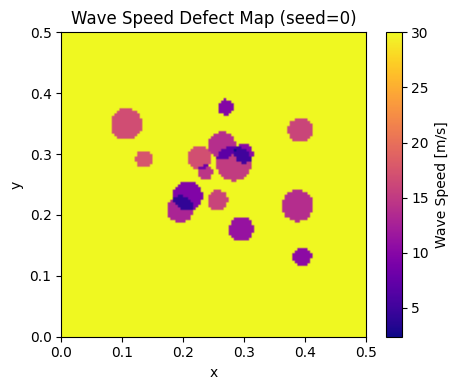

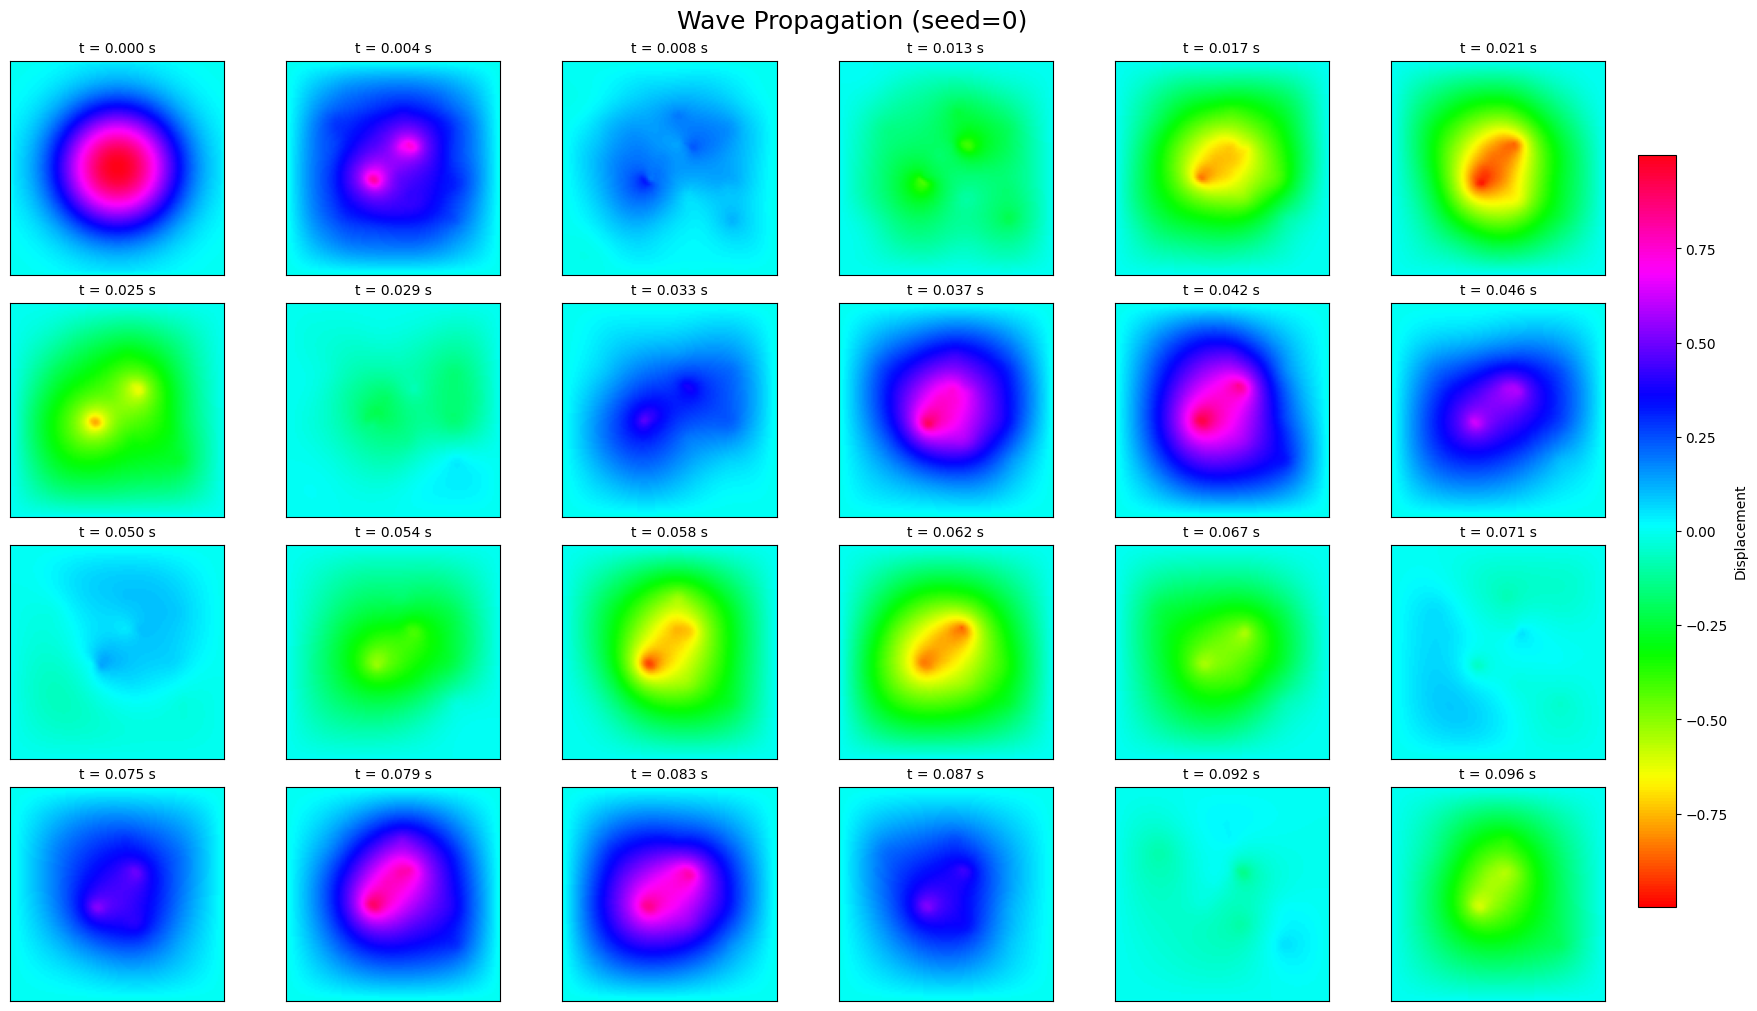

Running simulation with seed 1...


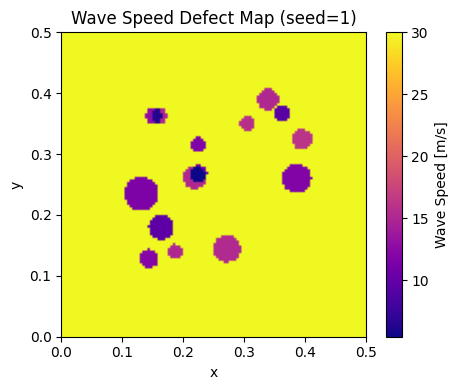

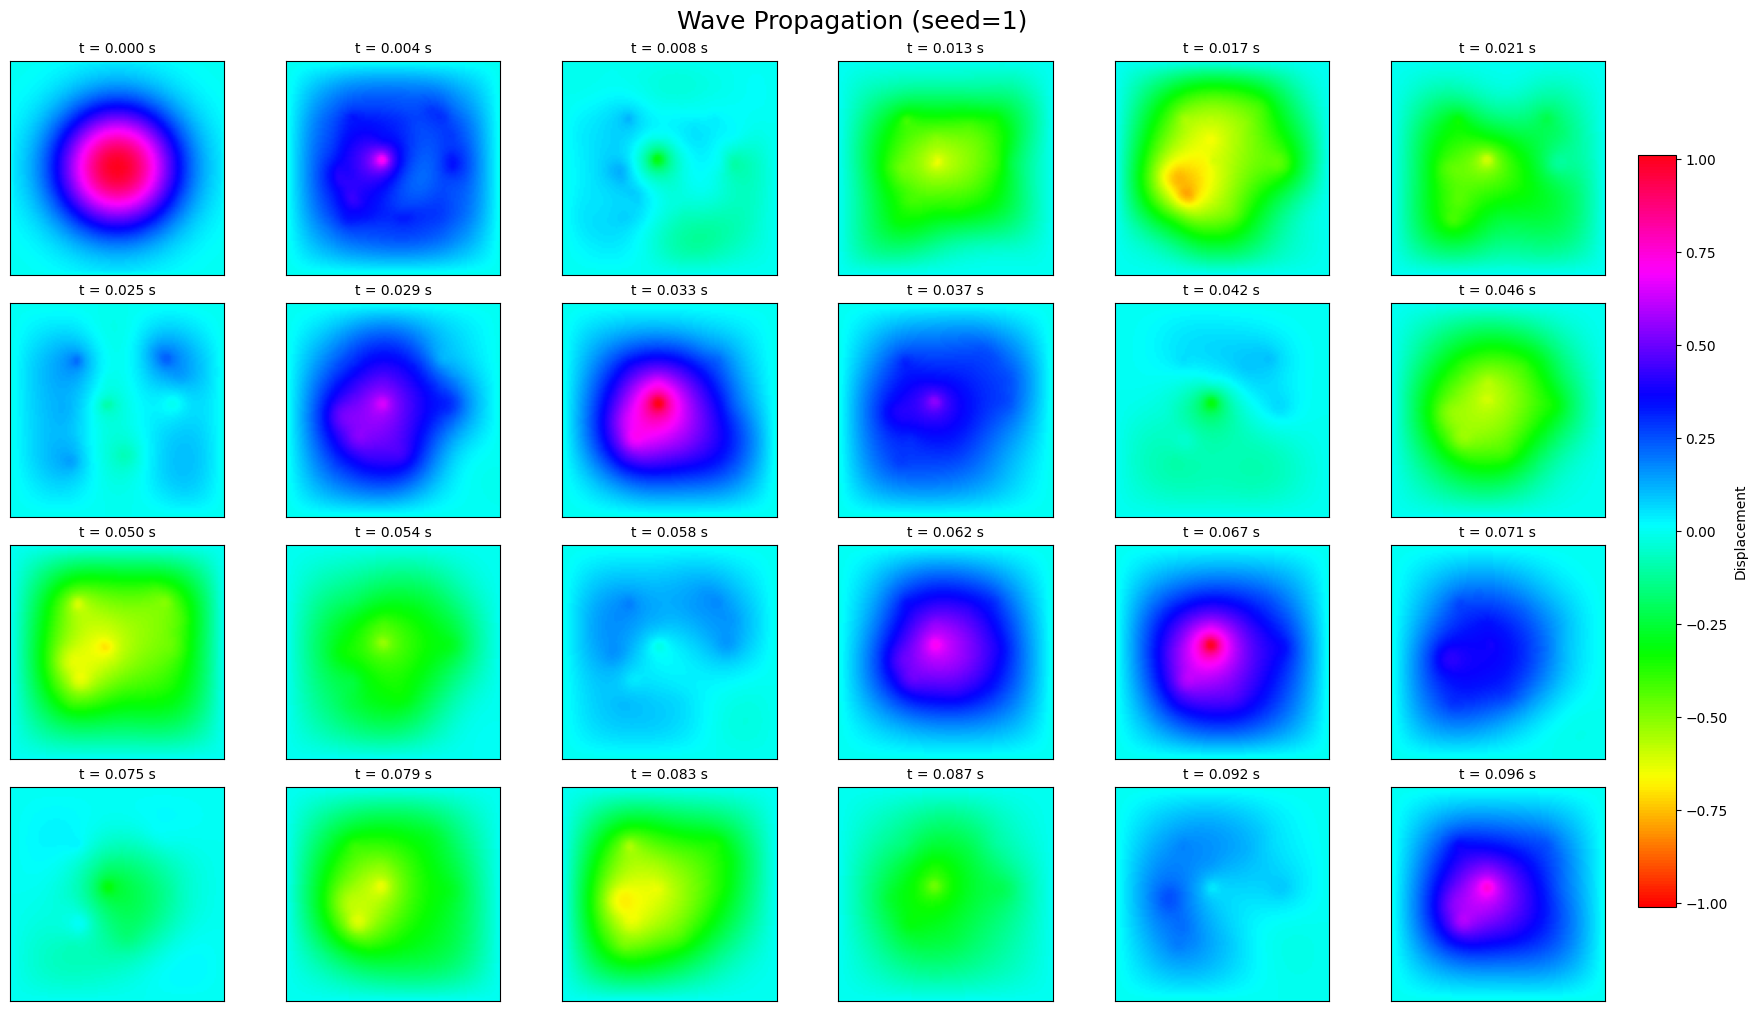

Running simulation with seed 2...


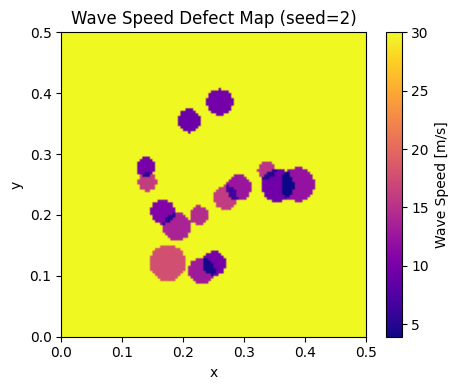

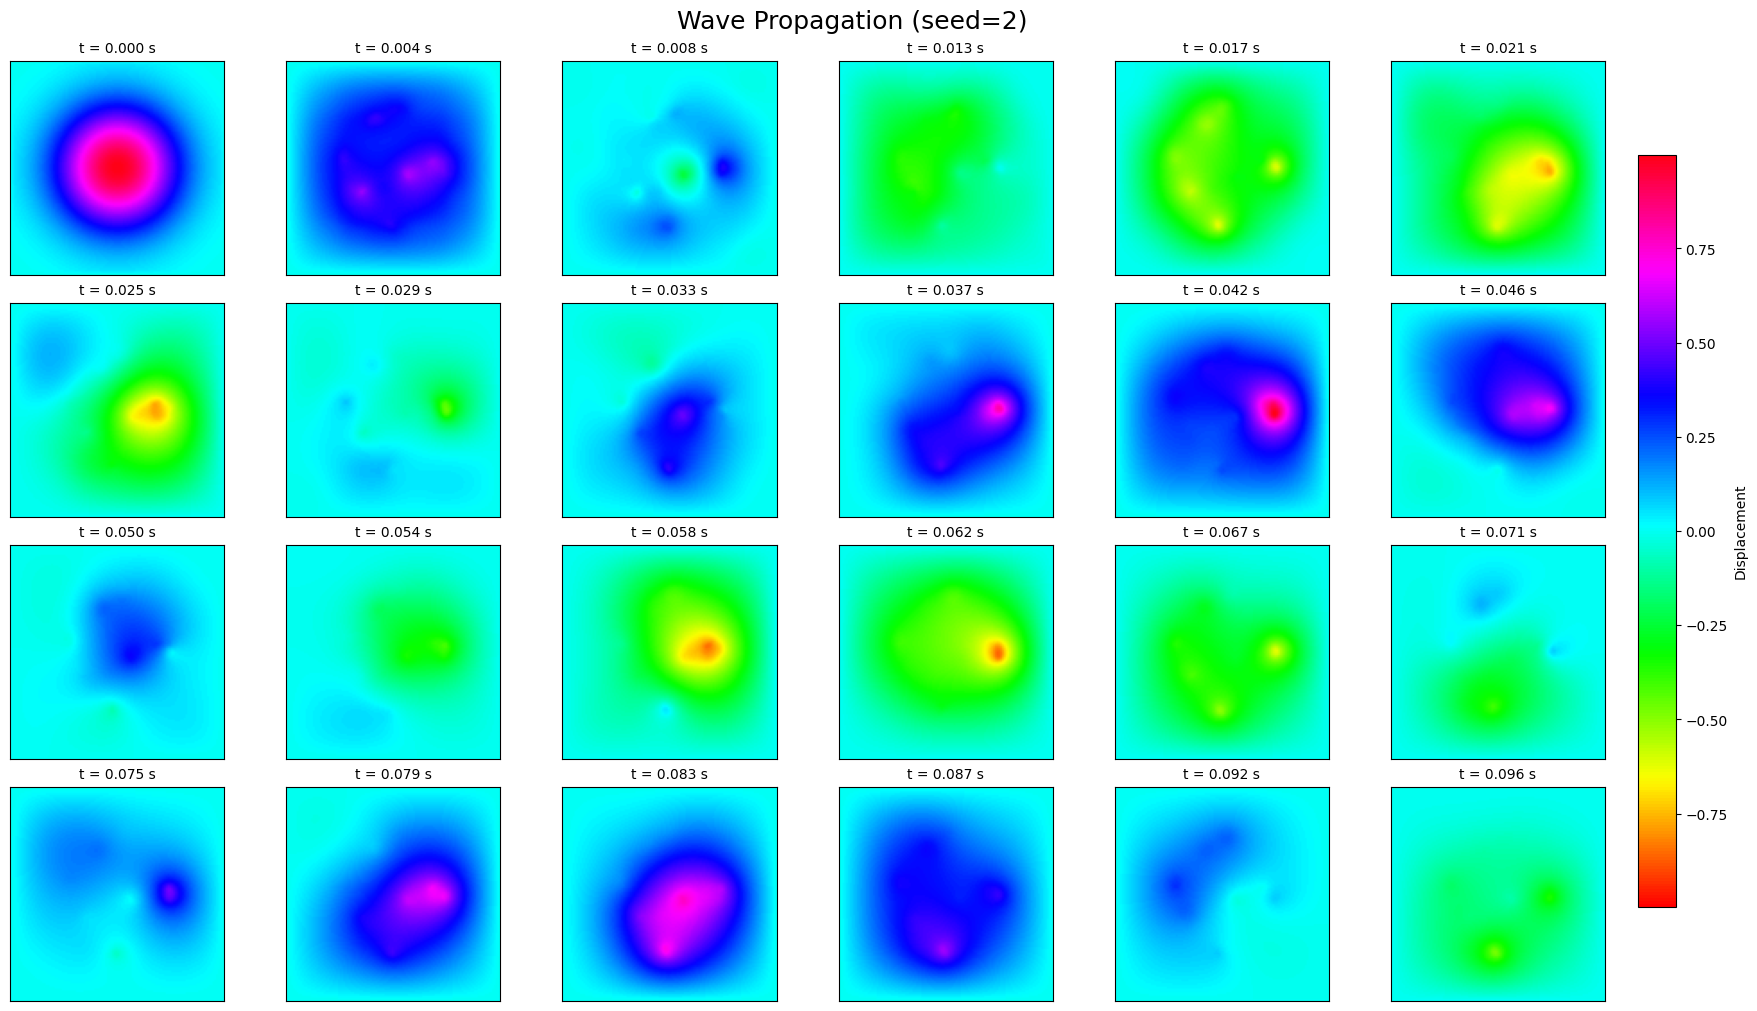

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve
# === Parameters ===
Lx = Ly = 0.5
c0 = 30
T = 0.1  # Total simulation time
dt = 0.0001
timesteps = int(T / dt)
def laplacian_1d(N, h):
    e = np.ones(N)
    return diags([e[:-1], -2 * e, e[:-1]], [-1, 0, 1], shape=(N, N)) / h ** 2
def laplacian_2d(Nx_int, Ny_int, dx, dy):
    Ix, Iy = identity(Nx_int), identity(Ny_int)
    Lx_1d = laplacian_1d(Nx_int, dx)
    Ly_1d = laplacian_1d(Ny_int, dy)
    return kron(Iy, Lx_1d) + kron(Ly_1d, Ix)
def make_defect_map(Nx, Ny, num_defects=15, seed=None):
    """Create a wave speed map with randomly placed circular defects."""
    if seed is not None:
        np.random.seed(seed)
    cx, cy = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), indexing='ij')
    c_map = c0 * np.ones((Nx, Ny))
    for _ in range(num_defects):
        x0, y0 = np.random.uniform(0.1, 0.4, 2)
        r = np.random.uniform(0.012, 0.03)  # Slightly smaller defects
        strength = np.random.uniform(0.3, 0.6)  # More pronounced (slower) defects
        mask = (cx - x0) ** 2 + (cy - y0) ** 2 <= r ** 2
        c_map[mask] *= strength
    return c_map
def run_sim(Nx, Ny, dt, timesteps, seed):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_i, Ny_i = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    # Initial Conditions
    u0 = np.exp(-50 * ((X - Lx / 2) ** 2 + (Y - Ly / 2) ** 2))
    u0[[0, -1], :] = 0
    u0[:, [0, -1]] = 0
    v0 = np.zeros_like(u0)
    flatten = lambda u: u[1:-1, 1:-1].ravel()
    pad = lambda U: np.pad(U.reshape(Nx_i, Ny_i), 1)
    c_map = make_defect_map(Nx, Ny, seed=seed)
    c_inner = flatten(c_map)
    u_hist = []
    u_n, v_n = flatten(u0), flatten(v0)
    for step in range(timesteps):
        c_sq = c_inner ** 2
        L = csc_matrix(laplacian_2d(Nx_i, Ny_i, dx, dy))
        C2 = diags(c_sq)
        A = identity(Nx_i * Ny_i) - 0.5 * dt ** 2 * (C2 @ L)
        B = identity(Nx_i * Ny_i) + 0.5 * dt ** 2 * (C2 @ L)
        rhs = B @ u_n + dt * v_n
        u_np1 = spsolve(A, rhs)
        v_np1 = (u_np1 - u_n) / dt
        u_n_full = pad(u_np1)
        # Enforce Dirichlet BCs strictly at each step
        u_n_full[0, :] = 0
        u_n_full[-1, :] = 0
        u_n_full[:, 0] = 0
        u_n_full[:, -1] = 0
        u_hist.append(u_n_full)
        u_n = flatten(u_n_full)
        v_n = v_np1
    return u_hist, c_map
# === Run Simulations with Different Seeds ===
Nx, Ny = 120, 120
seeds = [0, 1, 2]  # simulate 3 different defect configurations
for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    u_hist, c_map = run_sim(Nx, Ny, dt, timesteps, seed=seed)
    # Plot Wave Speed Map
    plt.figure(figsize=(5, 4))
    plt.imshow(c_map.T, origin='lower', cmap='plasma', extent=[0, Lx, 0, Ly])
    plt.colorbar(label='Wave Speed [m/s]')
    plt.title(f"Wave Speed Defect Map (seed={seed})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()
    # Plot Wave Field Snapshots at 24 Equally-Spaced Times
    frame_times = np.linspace(0, T, 24, endpoint=False)
    frame_indices = (frame_times / dt).astype(int)
    all_u_vals = np.array([u_hist[idx] for idx in frame_indices])
    absmax = np.max(np.abs(all_u_vals))
    fig, axes = plt.subplots(4, 6, figsize=(18, 10), constrained_layout=True)
    for ax, idx in zip(axes.flat, frame_indices):
        im = ax.imshow(u_hist[idx].T, origin='lower', cmap='hsv', extent=[0, Lx, 0, Ly],
                       vmin=-absmax, vmax=absmax)
        ax.set_title(f"t = {idx * dt:.3f} s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label('Displacement')
    fig.suptitle(f"Wave Propagation (seed={seed})", fontsize=18)
    plt.show()

### First, the defect strength is increased (local wave speed at the defect is decreased) by a factor of .75 for the same defect seeds.

Running simulation with seed 0...


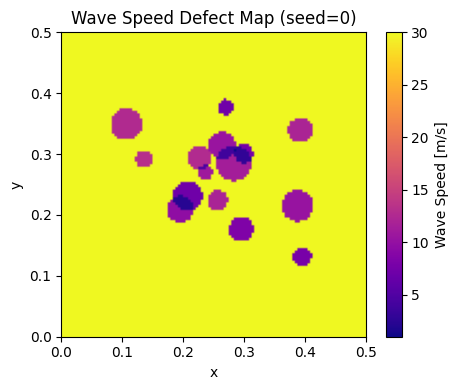

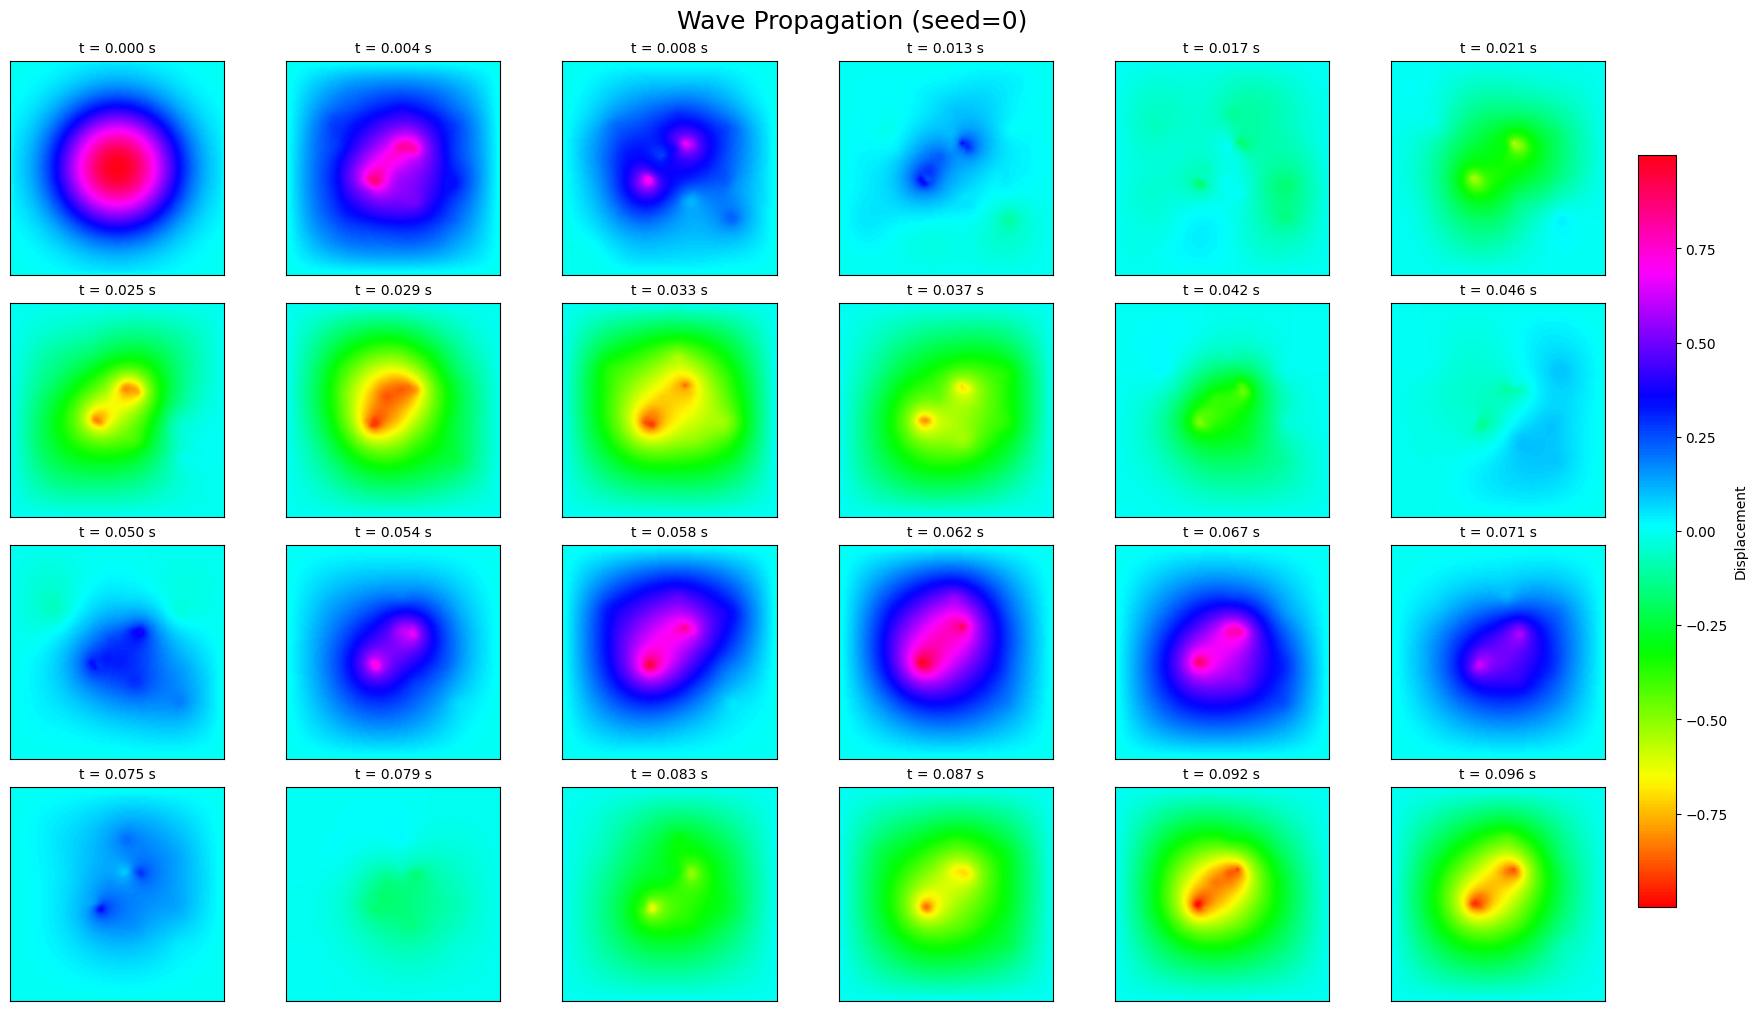

Running simulation with seed 1...


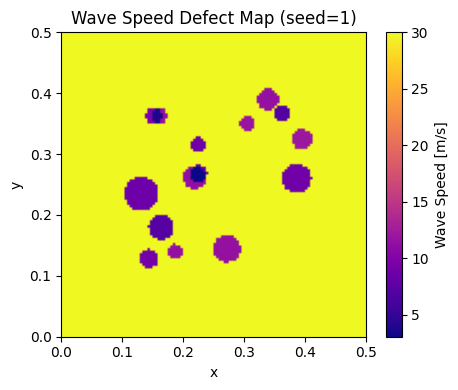

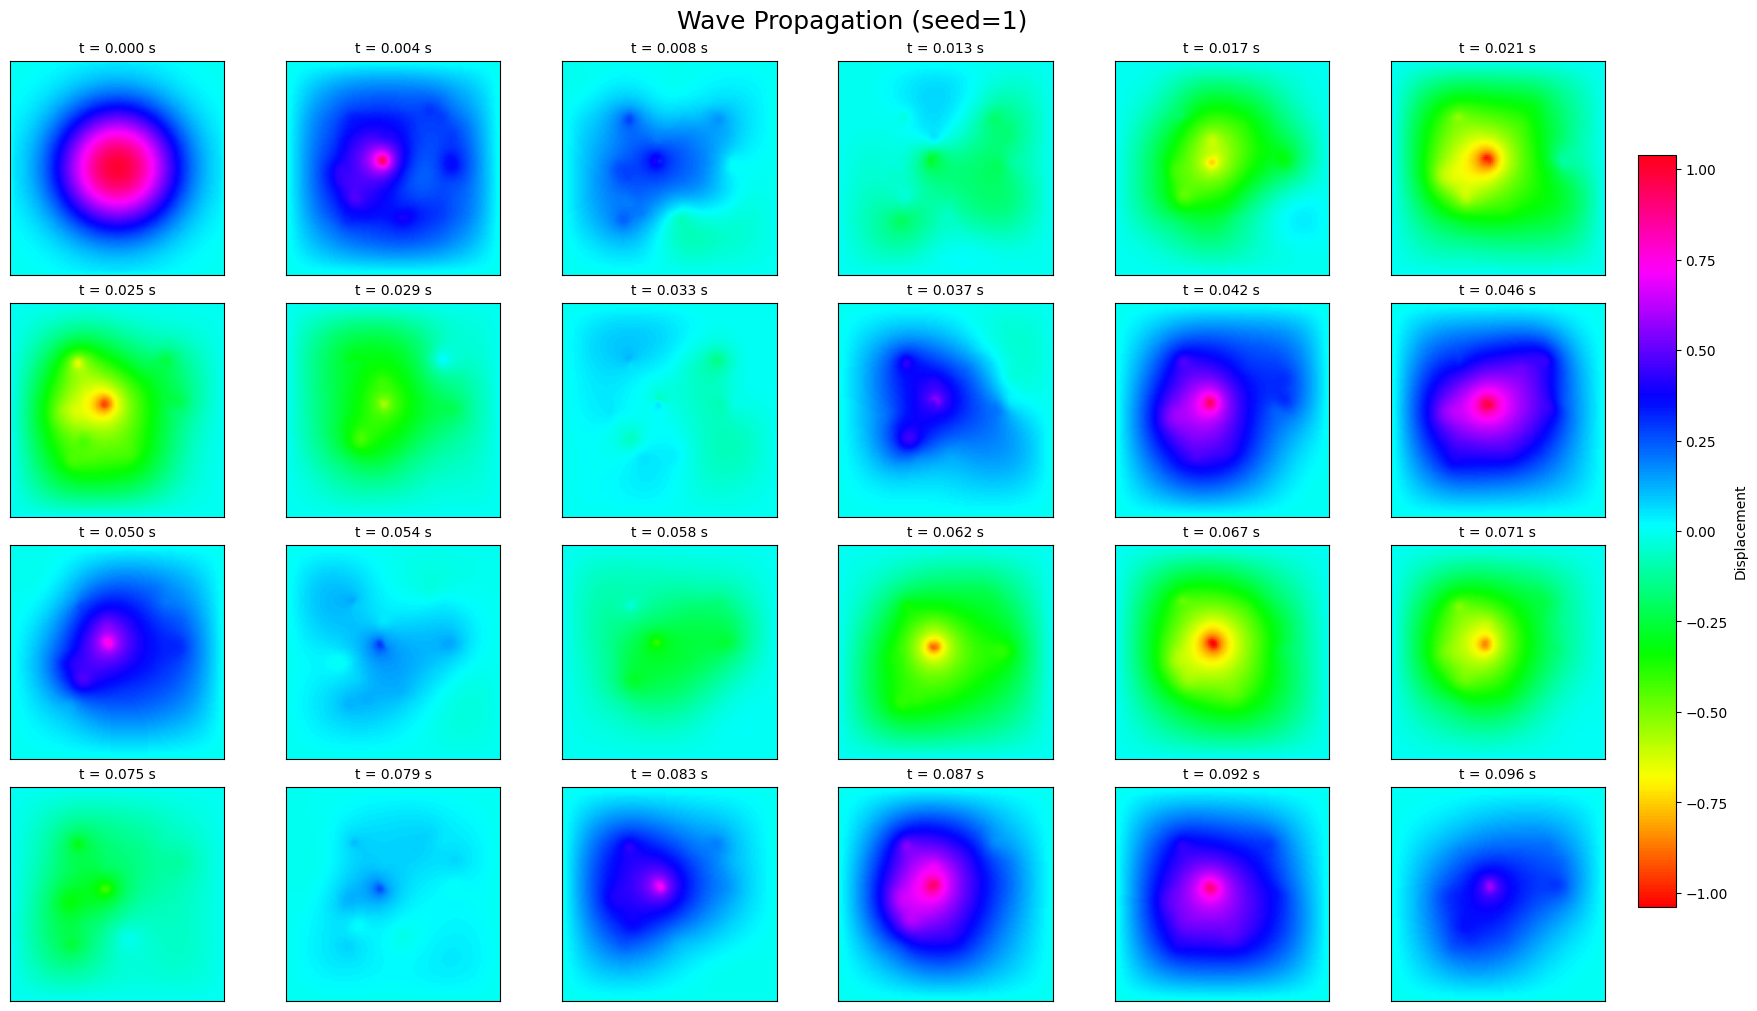

Running simulation with seed 2...


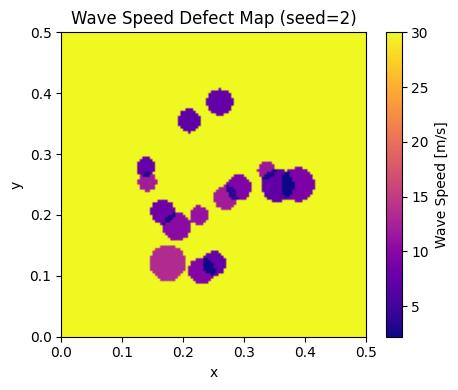

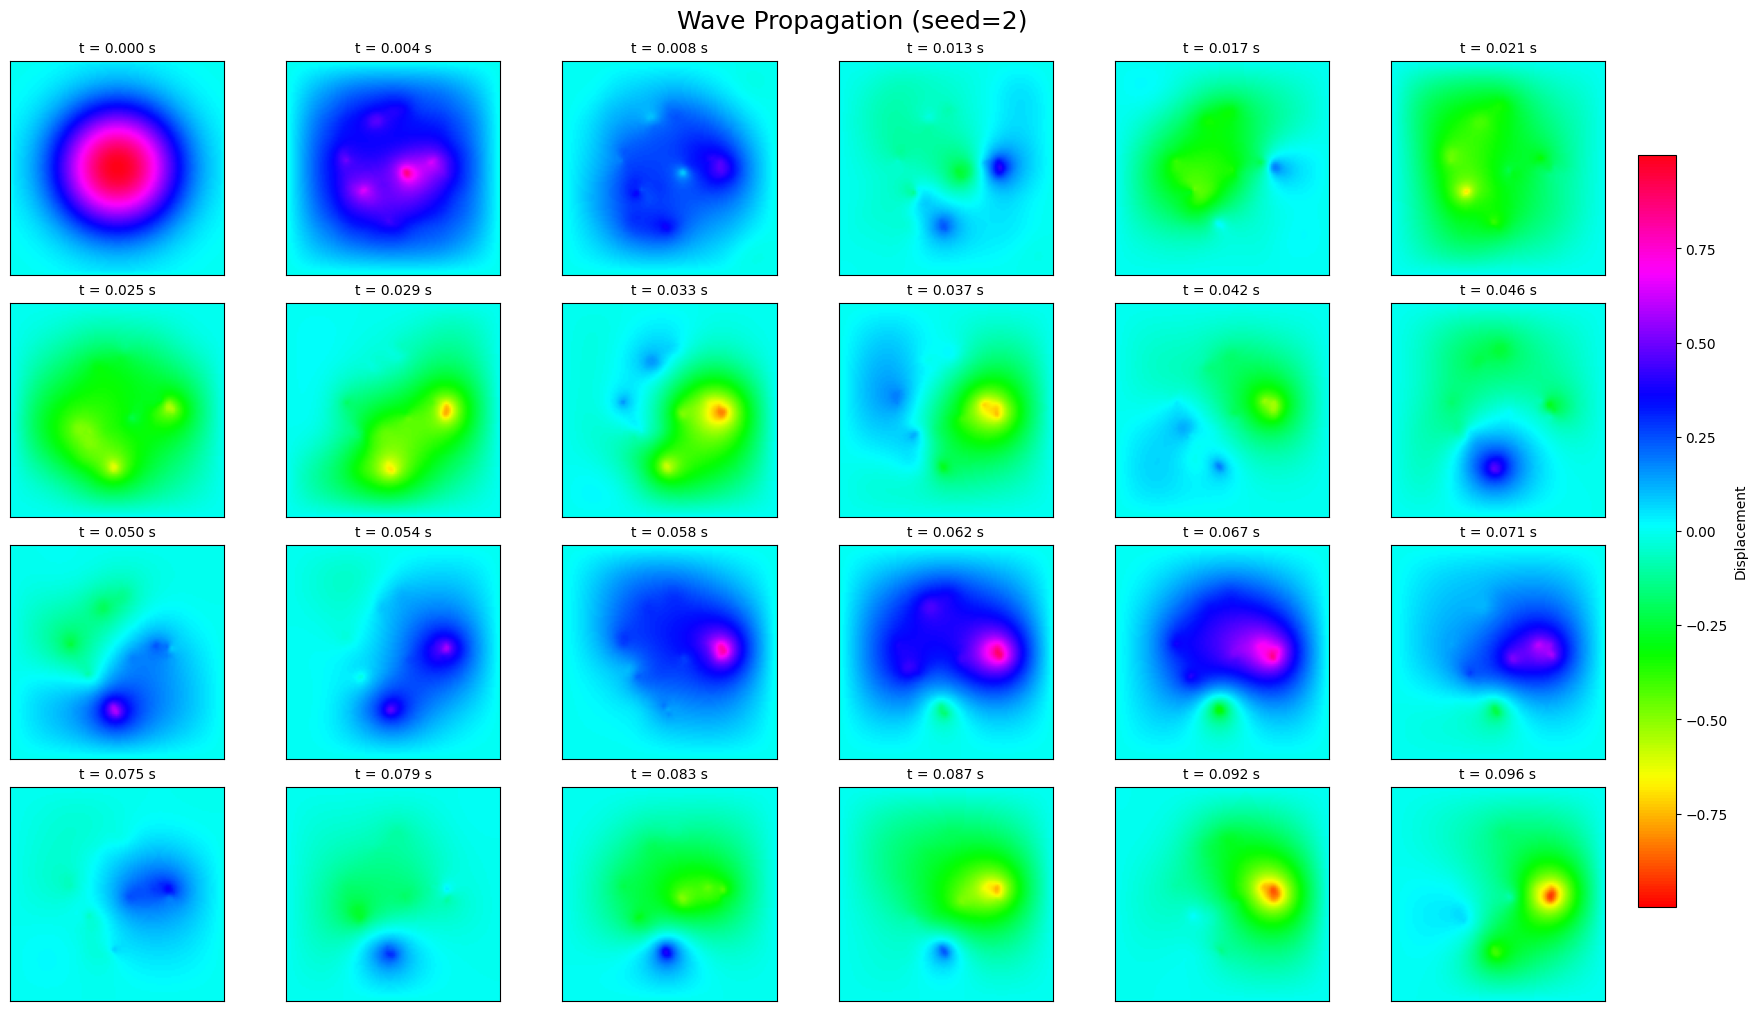

In [2]:
import numpy as np, matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve
# === Parameters ===
Lx = Ly = 0.5
c0 = 30
T = 0.1  # Total simulation time
dt = 0.0001
timesteps = int(T / dt)
def laplacian_1d(N, h):
    e = np.ones(N)
    return diags([e[:-1], -2 * e, e[:-1]], [-1, 0, 1], shape=(N, N)) / h ** 2
def laplacian_2d(Nx_int, Ny_int, dx, dy):
    Ix, Iy = identity(Nx_int), identity(Ny_int)
    Lx_1d = laplacian_1d(Nx_int, dx)
    Ly_1d = laplacian_1d(Ny_int, dy)
    return kron(Iy, Lx_1d) + kron(Ly_1d, Ix)
def make_defect_map(Nx, Ny, num_defects=15, seed=None):
    """Create a wave speed map with randomly placed circular defects."""
    if seed is not None:
        np.random.seed(seed)
    cx, cy = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), indexing='ij')
    c_map = c0 * np.ones((Nx, Ny))
    for _ in range(num_defects):
        x0, y0 = np.random.uniform(0.1, 0.4, 2)
        r = np.random.uniform(0.012, 0.03)  # Slightly smaller defects
        strength = .75*np.random.uniform(0.3, 0.6)  # More pronounced (slower) defects
        mask = (cx - x0) ** 2 + (cy - y0) ** 2 <= r ** 2
        c_map[mask] *= strength
    return c_map
def run_sim(Nx, Ny, dt, timesteps, seed):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_i, Ny_i = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    # Initial Conditions
    u0 = np.exp(-50 * ((X - Lx / 2) ** 2 + (Y - Ly / 2) ** 2))
    u0[[0, -1], :] = 0
    u0[:, [0, -1]] = 0
    v0 = np.zeros_like(u0)
    flatten = lambda u: u[1:-1, 1:-1].ravel()
    pad = lambda U: np.pad(U.reshape(Nx_i, Ny_i), 1)
    c_map = make_defect_map(Nx, Ny, seed=seed)
    c_inner = flatten(c_map)
    u_hist = []
    u_n, v_n = flatten(u0), flatten(v0)
    for step in range(timesteps):
        c_sq = c_inner ** 2
        L = csc_matrix(laplacian_2d(Nx_i, Ny_i, dx, dy))
        C2 = diags(c_sq)
        A = identity(Nx_i * Ny_i) - 0.5 * dt ** 2 * (C2 @ L)
        B = identity(Nx_i * Ny_i) + 0.5 * dt ** 2 * (C2 @ L)
        rhs = B @ u_n + dt * v_n
        u_np1 = spsolve(A, rhs)
        v_np1 = (u_np1 - u_n) / dt
        u_n_full = pad(u_np1)
        # Enforce Dirichlet BCs strictly each step
        u_n_full[0, :] = 0
        u_n_full[-1, :] = 0
        u_n_full[:, 0] = 0
        u_n_full[:, -1] = 0
        u_hist.append(u_n_full)
        u_n = flatten(u_n_full)
        v_n = v_np1
    return u_hist, c_map
# === Run Simulations with Different Seeds ===
Nx, Ny = 120, 120
seeds = [0, 1, 2]  # simulate 3 different defect configurations
for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    u_hist, c_map = run_sim(Nx, Ny, dt, timesteps, seed=seed)
    # Plot Wave Speed Map
    plt.figure(figsize=(5, 4))
    plt.imshow(c_map.T, origin='lower', cmap='plasma', extent=[0, Lx, 0, Ly])
    plt.colorbar(label='Wave Speed [m/s]')
    plt.title(f"Wave Speed Defect Map (seed={seed})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()
    # Plot Wave Field Snapshots at 24 Equally-Spaced Times
    frame_times = np.linspace(0, T, 24, endpoint=False)
    frame_indices = (frame_times / dt).astype(int)
    all_u_vals = np.array([u_hist[idx] for idx in frame_indices])
    absmax = np.max(np.abs(all_u_vals))
    fig, axes = plt.subplots(4, 6, figsize=(18, 10), constrained_layout=True)
    for ax, idx in zip(axes.flat, frame_indices):
        im = ax.imshow(u_hist[idx].T, origin='lower', cmap='hsv', extent=[0, Lx, 0, Ly],
                       vmin=-absmax, vmax=absmax)
        ax.set_title(f"t = {idx * dt:.3f} s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label('Displacement')
    fig.suptitle(f"Wave Propagation (seed={seed})", fontsize=18)
    plt.show()

### Then, the defect strength is increased (local wave speed at the defect is decreased) by a factor of .5 for the same defect seeds.

Running simulation with seed 0...


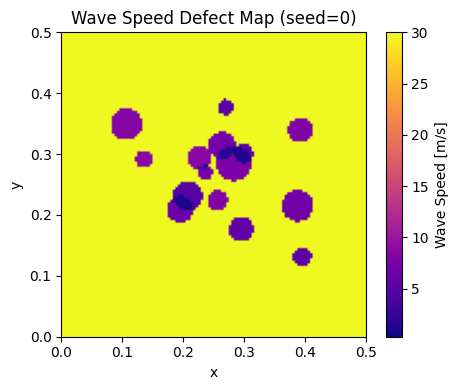

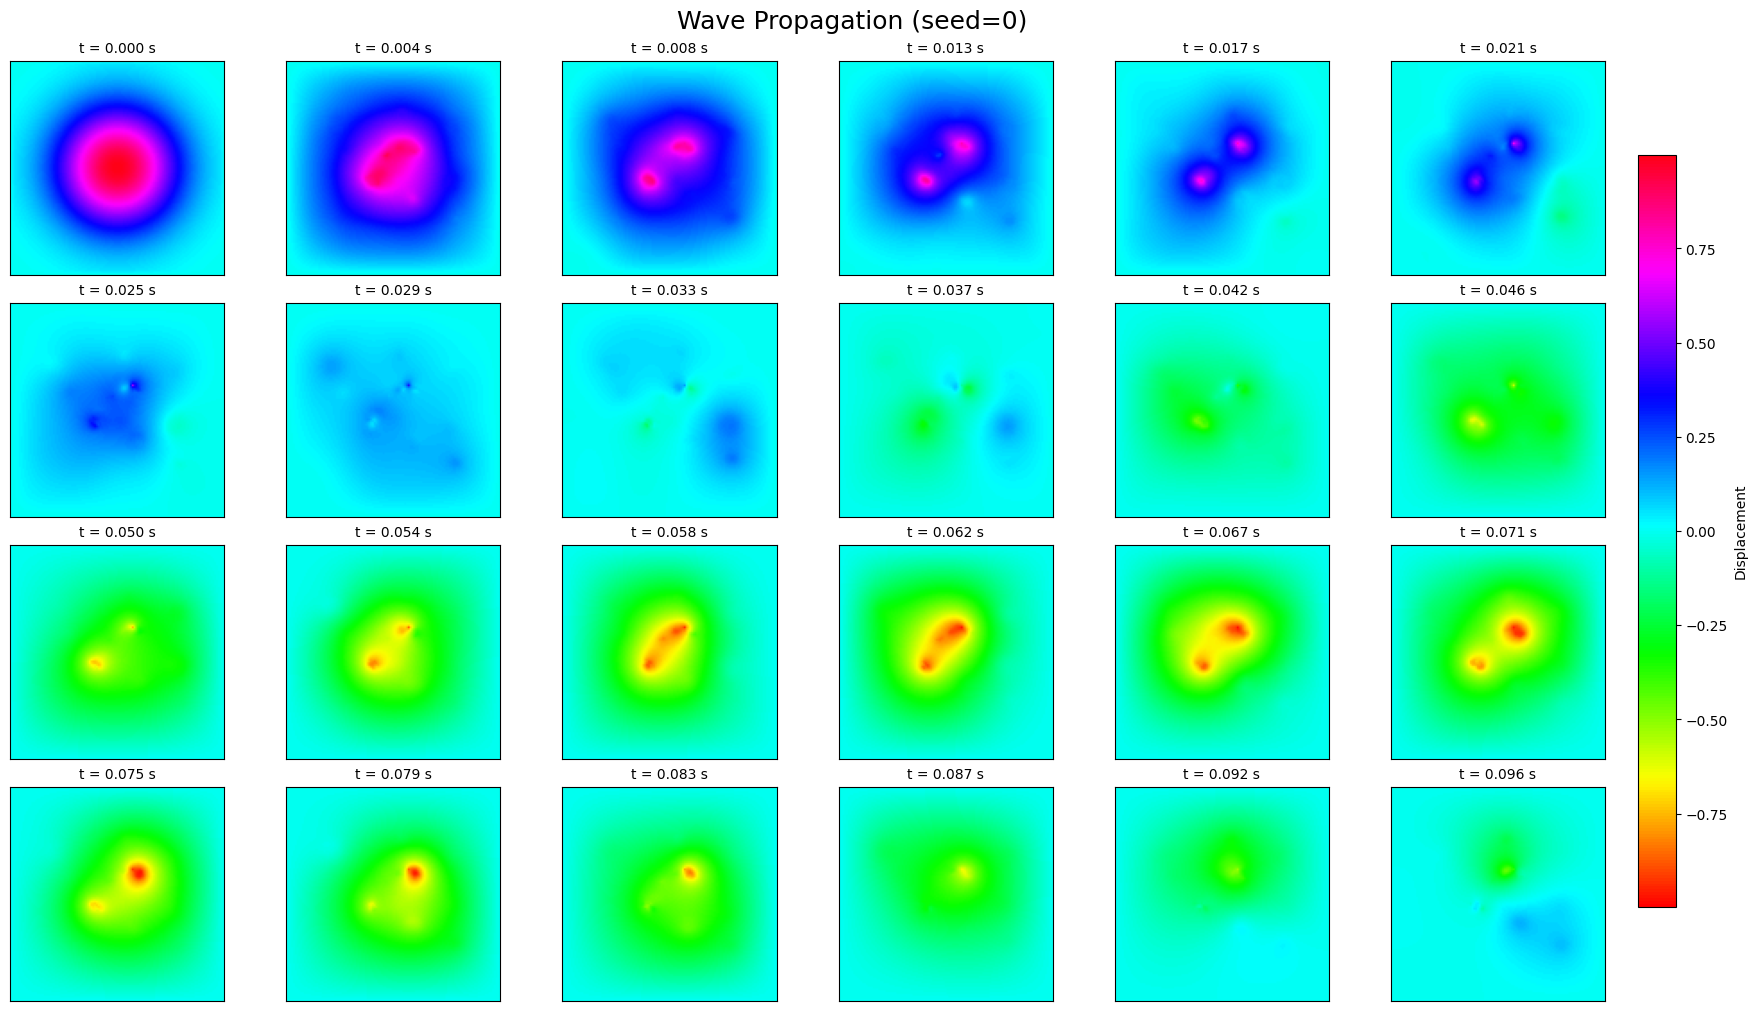

Running simulation with seed 1...


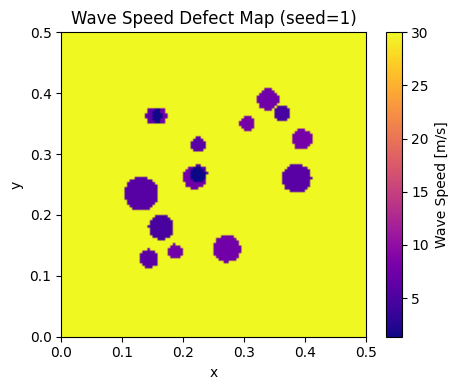

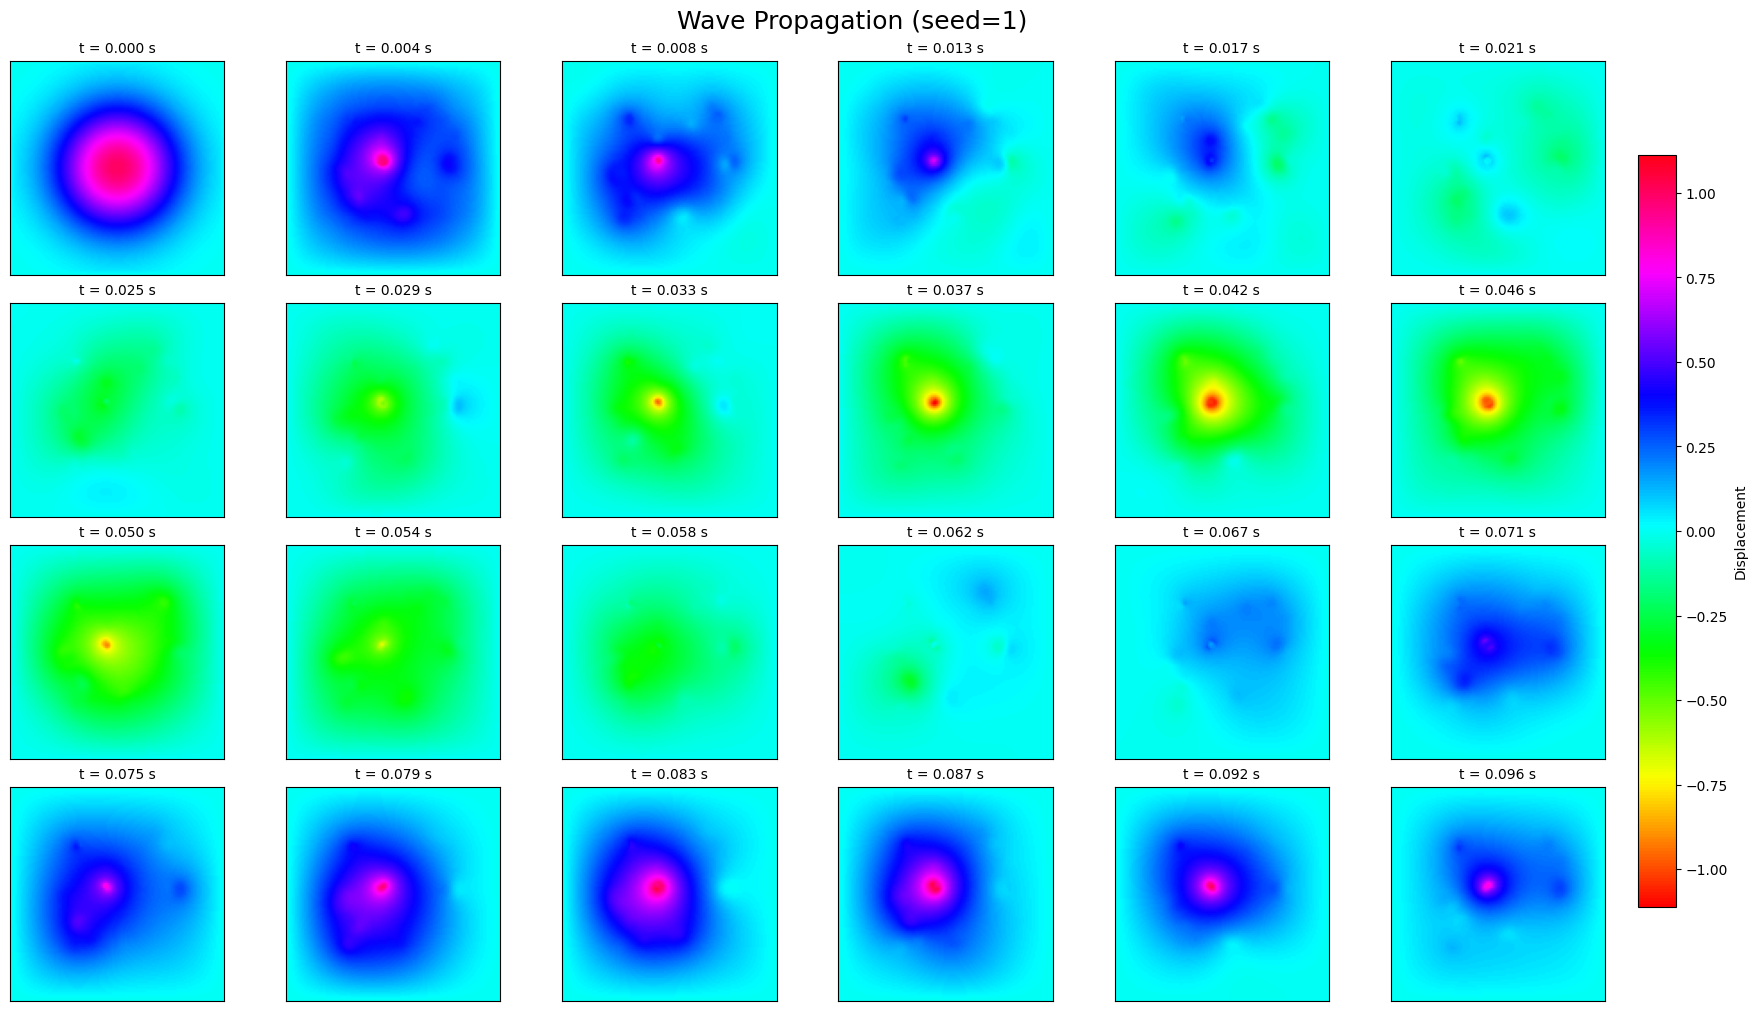

Running simulation with seed 2...


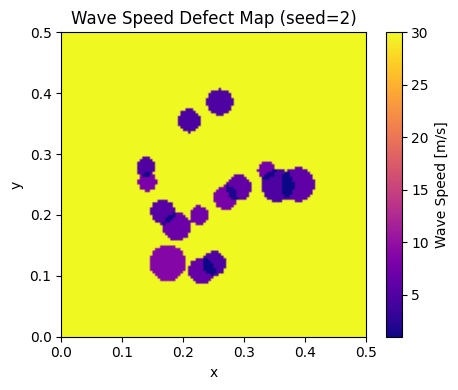

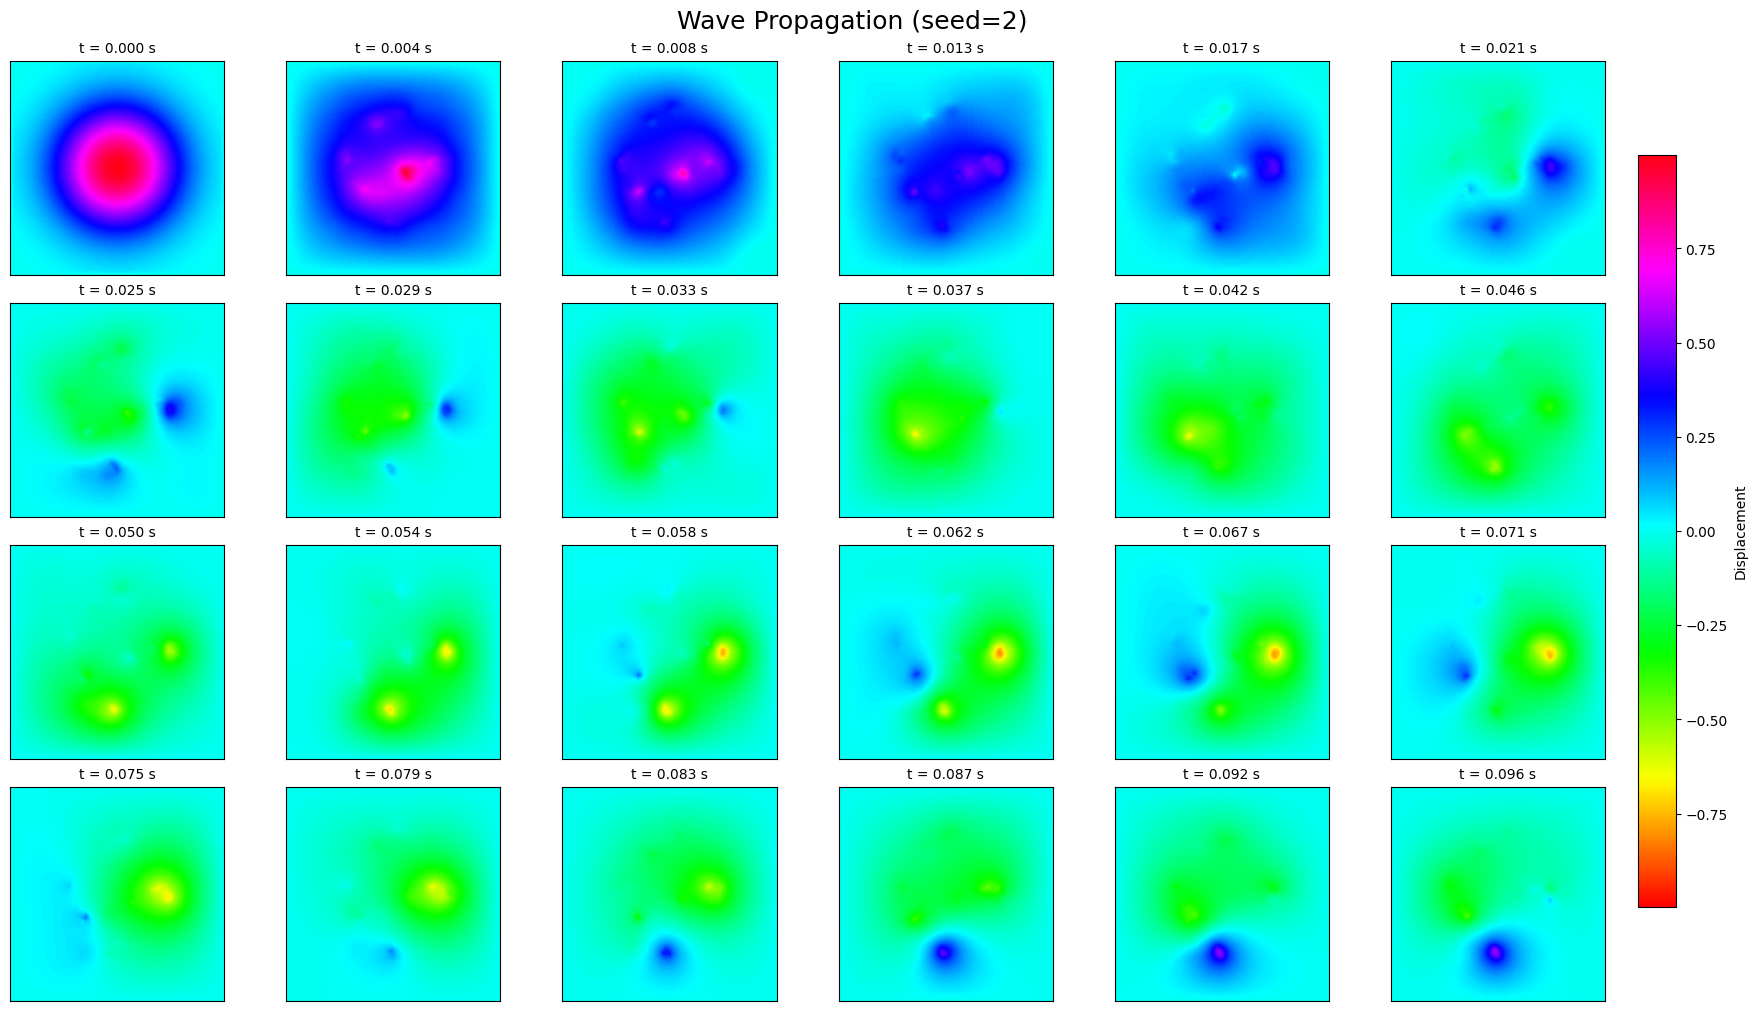

In [3]:
import numpy as np, matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve
# === Parameters ===
Lx = Ly = 0.5
c0 = 30
T = 0.1  # Total simulation time
dt = 0.0001
timesteps = int(T / dt)
def laplacian_1d(N, h):
    e = np.ones(N)
    return diags([e[:-1], -2 * e, e[:-1]], [-1, 0, 1], shape=(N, N)) / h ** 2
def laplacian_2d(Nx_int, Ny_int, dx, dy):
    Ix, Iy = identity(Nx_int), identity(Ny_int)
    Lx_1d = laplacian_1d(Nx_int, dx)
    Ly_1d = laplacian_1d(Ny_int, dy)
    return kron(Iy, Lx_1d) + kron(Ly_1d, Ix)
def make_defect_map(Nx, Ny, num_defects=15, seed=None):
    """Create a wave speed map with randomly placed circular defects."""
    if seed is not None:
        np.random.seed(seed)
    cx, cy = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), indexing='ij')
    c_map = c0 * np.ones((Nx, Ny))
    for _ in range(num_defects):
        x0, y0 = np.random.uniform(0.1, 0.4, 2)
        r = np.random.uniform(0.012, 0.03)  # Slightly smaller defects
        strength = .5*np.random.uniform(0.3, 0.6)  # More pronounced (slower) defects
        mask = (cx - x0) ** 2 + (cy - y0) ** 2 <= r ** 2
        c_map[mask] *= strength
    return c_map
def run_sim(Nx, Ny, dt, timesteps, seed):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_i, Ny_i = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    # Initial Conditions
    u0 = np.exp(-50 * ((X - Lx / 2) ** 2 + (Y - Ly / 2) ** 2))
    u0[[0, -1], :] = 0
    u0[:, [0, -1]] = 0
    v0 = np.zeros_like(u0)
    flatten = lambda u: u[1:-1, 1:-1].ravel()
    pad = lambda U: np.pad(U.reshape(Nx_i, Ny_i), 1)
    c_map = make_defect_map(Nx, Ny, seed=seed)
    c_inner = flatten(c_map)
    u_hist = []
    u_n, v_n = flatten(u0), flatten(v0)
    for step in range(timesteps):
        c_sq = c_inner ** 2
        L = csc_matrix(laplacian_2d(Nx_i, Ny_i, dx, dy))
        C2 = diags(c_sq)
        A = identity(Nx_i * Ny_i) - 0.5 * dt ** 2 * (C2 @ L)
        B = identity(Nx_i * Ny_i) + 0.5 * dt ** 2 * (C2 @ L)
        rhs = B @ u_n + dt * v_n
        u_np1 = spsolve(A, rhs)
        v_np1 = (u_np1 - u_n) / dt
        u_n_full = pad(u_np1)
        # Enforce Dirichlet BCs strictly each step
        u_n_full[0, :] = 0
        u_n_full[-1, :] = 0
        u_n_full[:, 0] = 0
        u_n_full[:, -1] = 0
        u_hist.append(u_n_full)
        u_n = flatten(u_n_full)
        v_n = v_np1
    return u_hist, c_map
# === Run Simulations with Different Seeds ===
Nx, Ny = 120, 120
seeds = [0, 1, 2]  # simulate 3 different defect configurations
for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    u_hist, c_map = run_sim(Nx, Ny, dt, timesteps, seed=seed)
    # Plot Wave Speed Map
    plt.figure(figsize=(5, 4))
    plt.imshow(c_map.T, origin='lower', cmap='plasma', extent=[0, Lx, 0, Ly])
    plt.colorbar(label='Wave Speed [m/s]')
    plt.title(f"Wave Speed Defect Map (seed={seed})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()
    # Plot Wave Field Snapshots at 24 Equally-Spaced Times
    frame_times = np.linspace(0, T, 24, endpoint=False)
    frame_indices = (frame_times / dt).astype(int)
    all_u_vals = np.array([u_hist[idx] for idx in frame_indices])
    absmax = np.max(np.abs(all_u_vals))
    fig, axes = plt.subplots(4, 6, figsize=(18, 10), constrained_layout=True)
    for ax, idx in zip(axes.flat, frame_indices):
        im = ax.imshow(u_hist[idx].T, origin='lower', cmap='hsv', extent=[0, Lx, 0, Ly],
                       vmin=-absmax, vmax=absmax)
        ax.set_title(f"t = {idx * dt:.3f} s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label('Displacement')
    fig.suptitle(f"Wave Propagation (seed={seed})", fontsize=18)
    plt.show()

### Then, the defect strength is increased (local wave speed at the defect is decreased) by a factor of 1.25 for the same defect seeds.

Running simulation with seed 0...


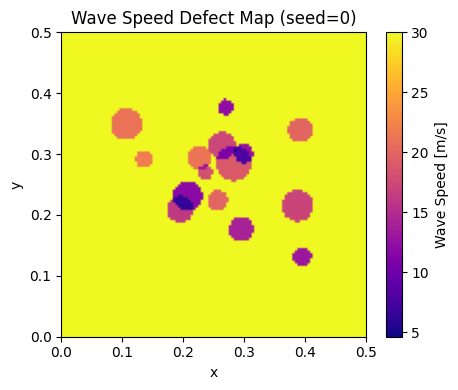

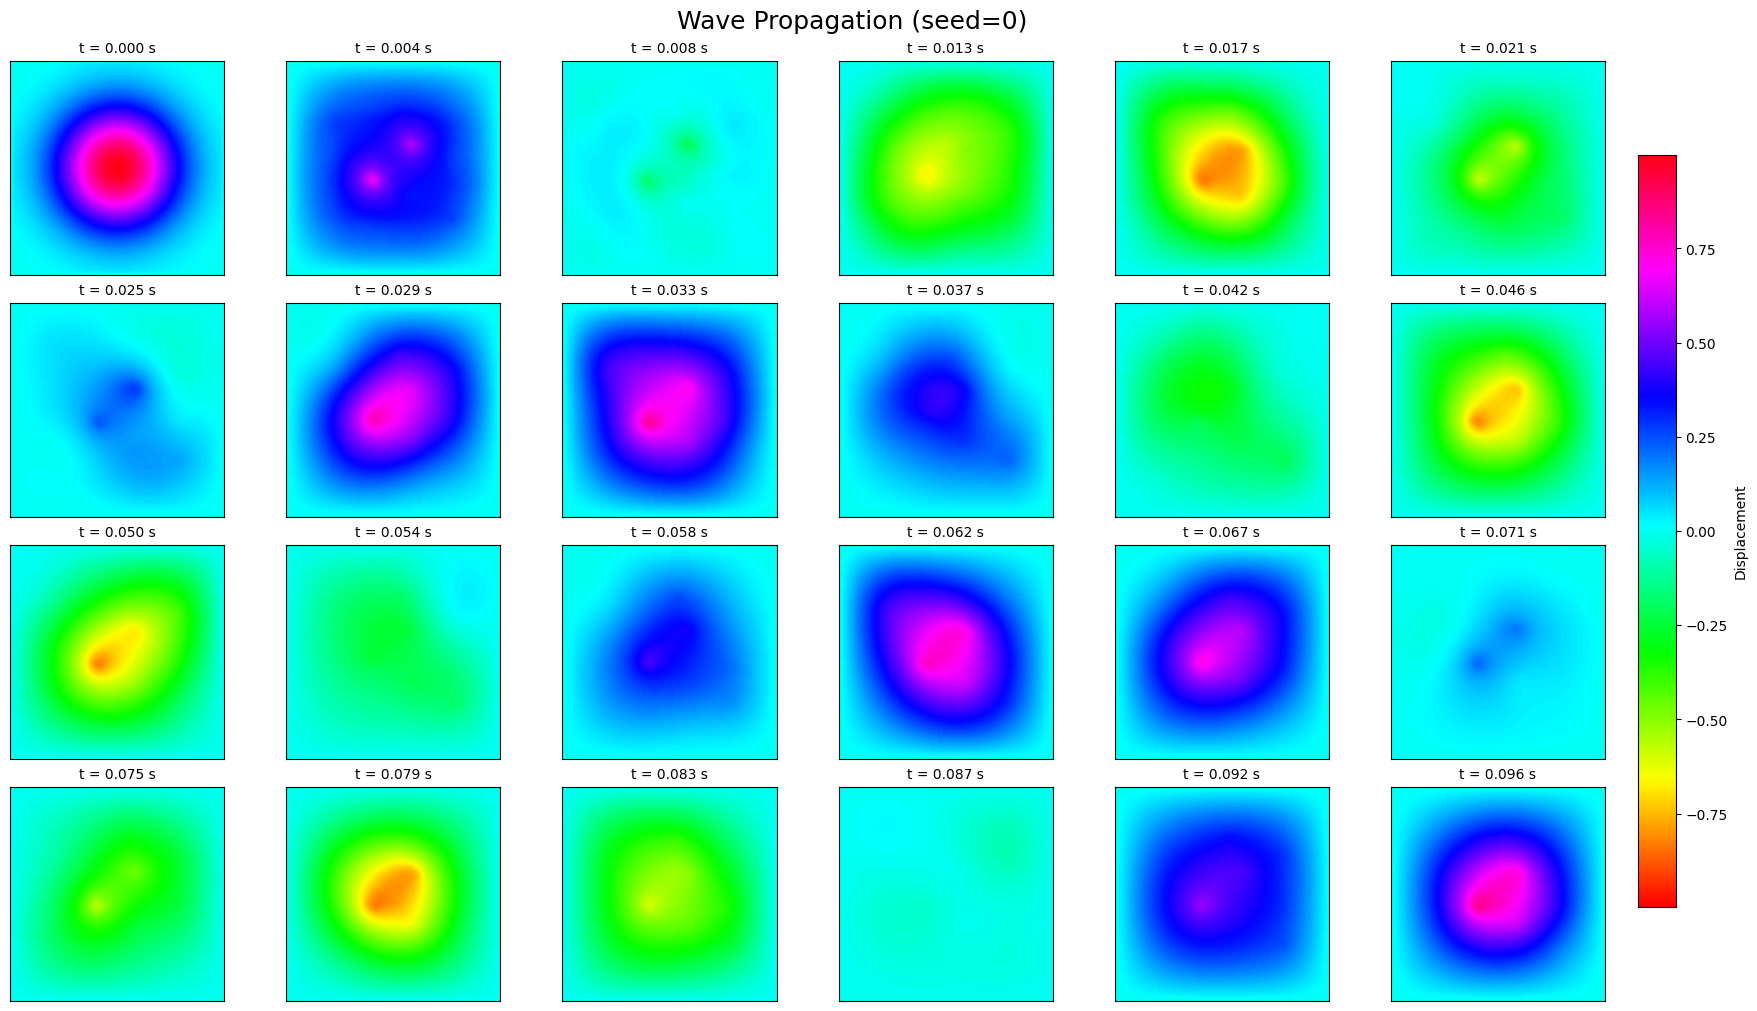

Running simulation with seed 1...


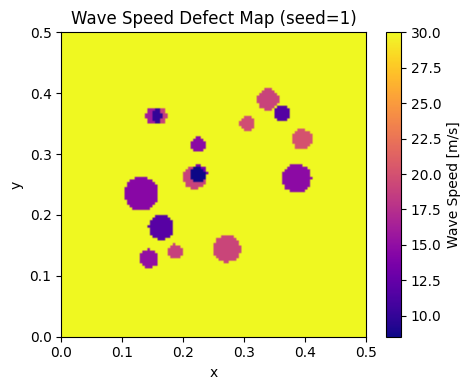

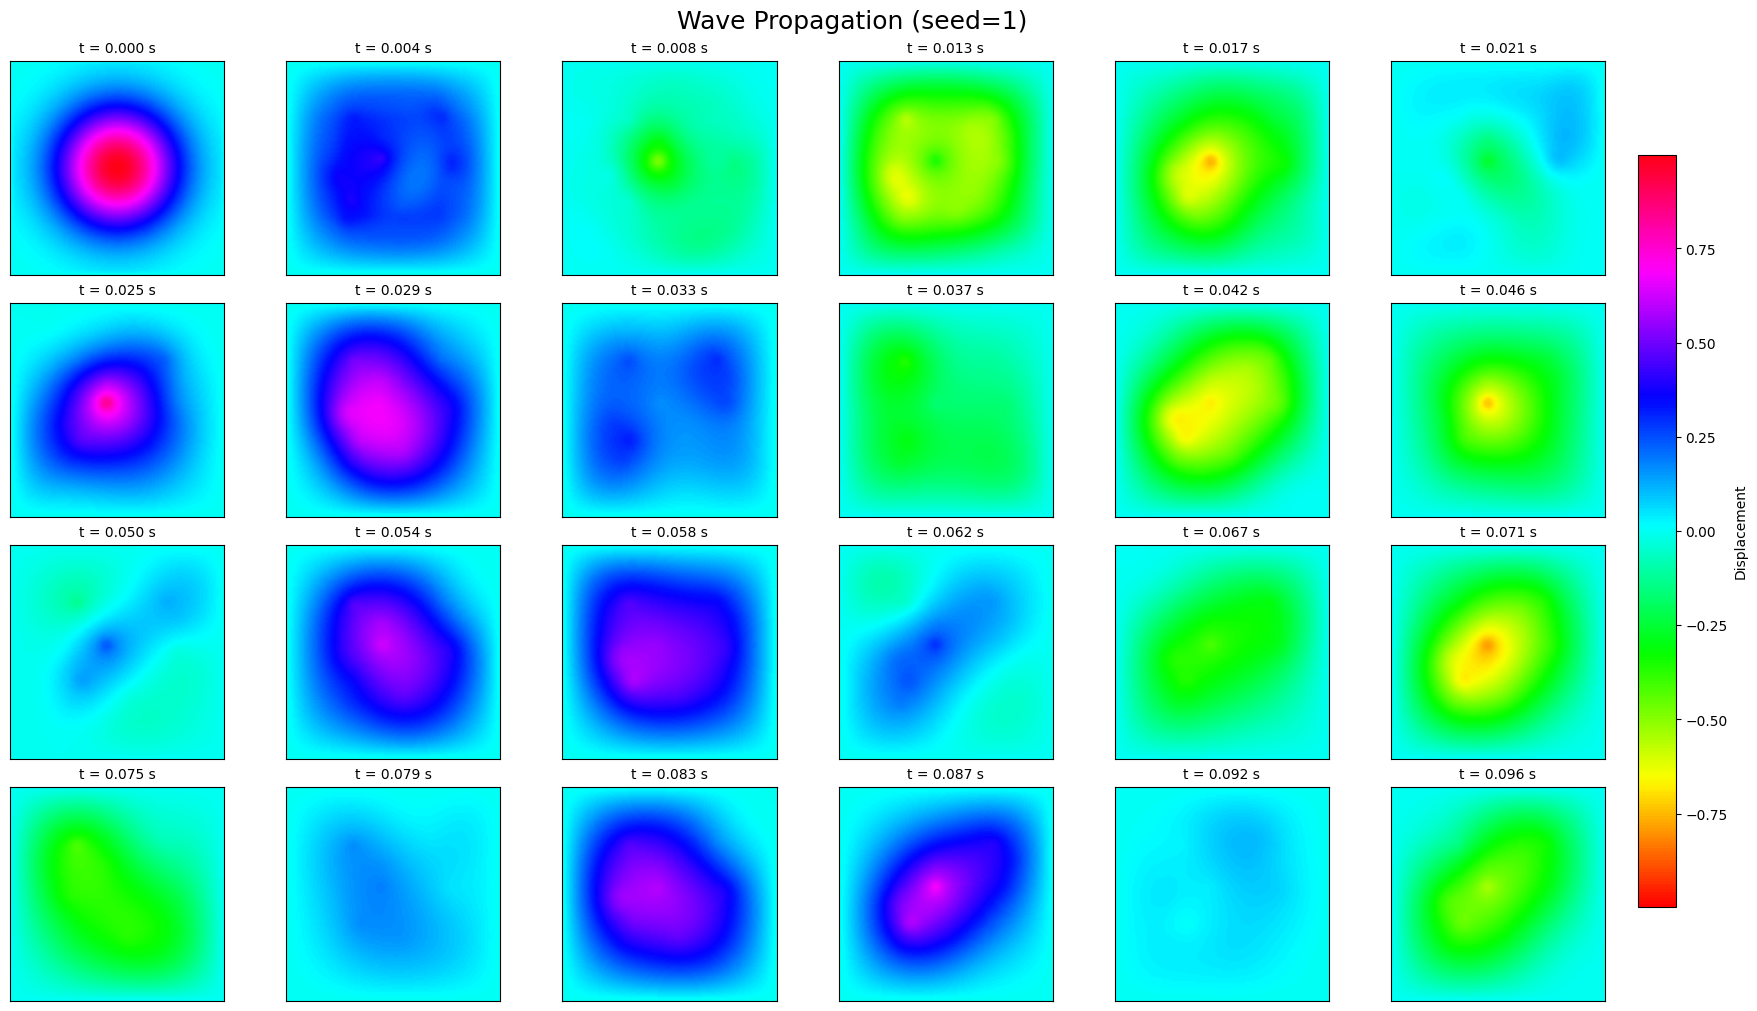

Running simulation with seed 2...


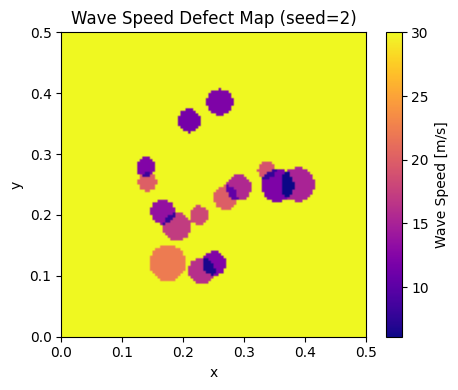

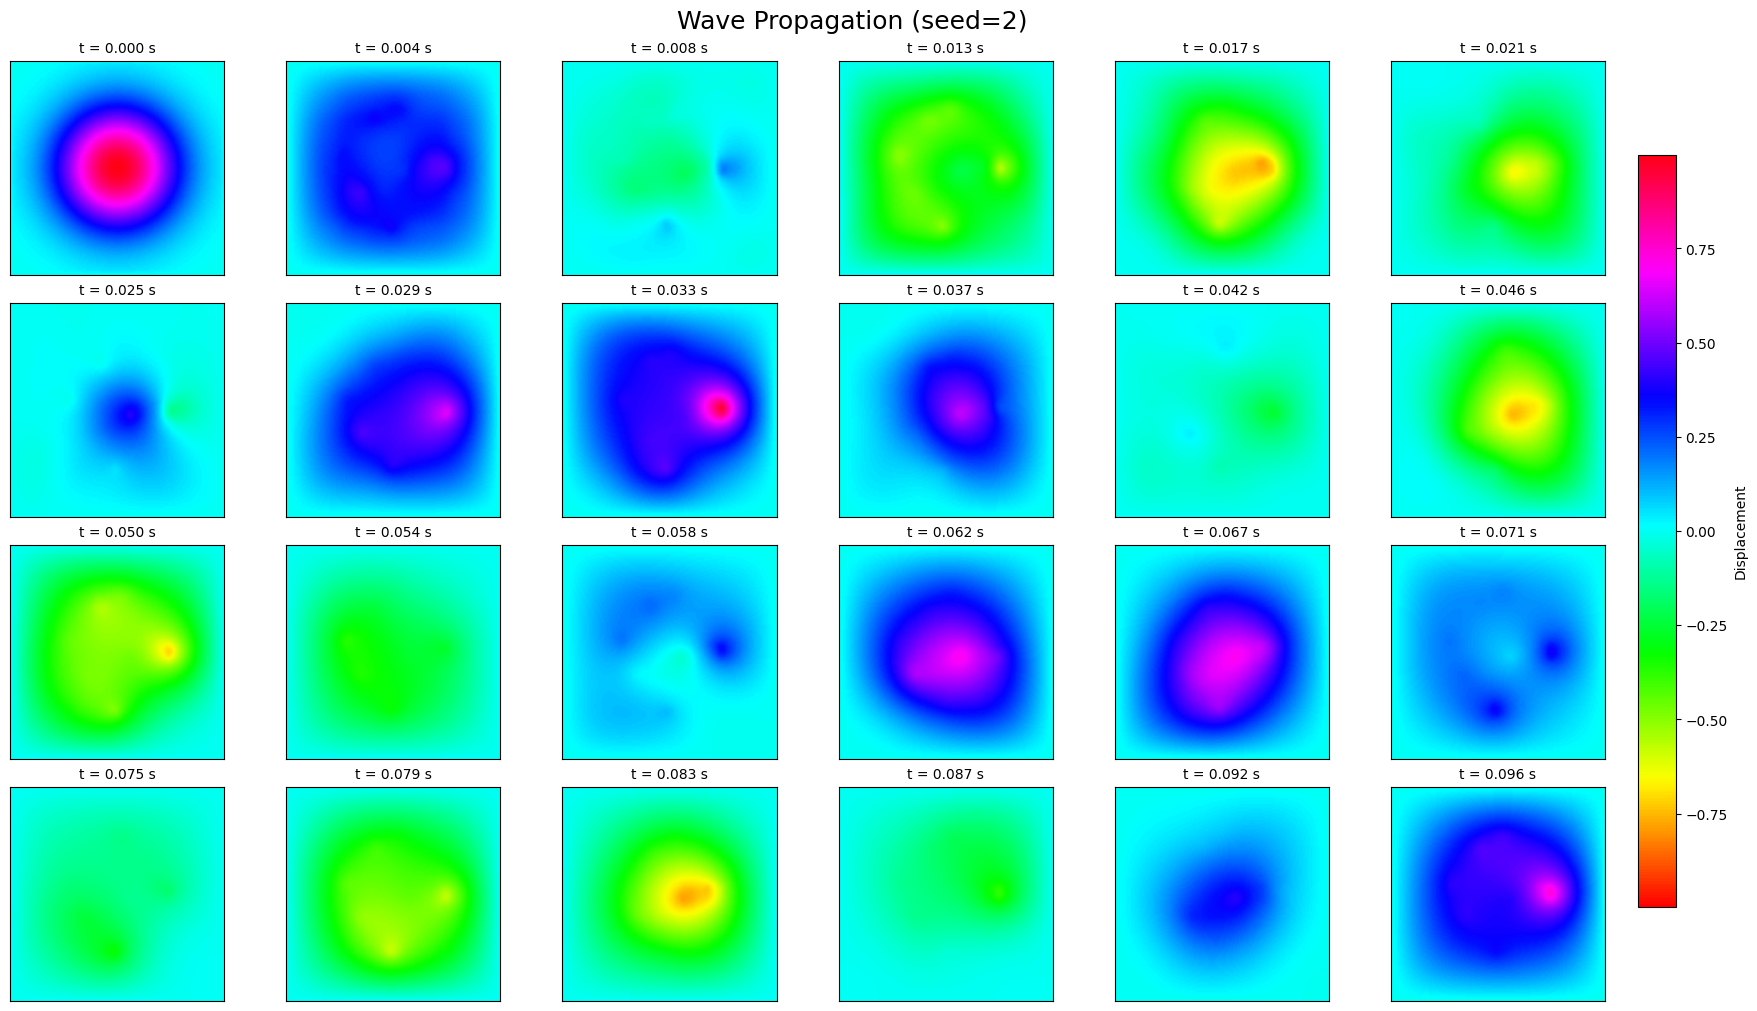

In [5]:
import numpy as np, matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve
# === Parameters ===
Lx = Ly = 0.5
c0 = 30
T = 0.1  # Total simulation time
dt = 0.0001
timesteps = int(T / dt)
def laplacian_1d(N, h):
    e = np.ones(N)
    return diags([e[:-1], -2 * e, e[:-1]], [-1, 0, 1], shape=(N, N)) / h ** 2
def laplacian_2d(Nx_int, Ny_int, dx, dy):
    Ix, Iy = identity(Nx_int), identity(Ny_int)
    Lx_1d = laplacian_1d(Nx_int, dx)
    Ly_1d = laplacian_1d(Ny_int, dy)
    return kron(Iy, Lx_1d) + kron(Ly_1d, Ix)
def make_defect_map(Nx, Ny, num_defects=15, seed=None):
    """Create a wave speed map with randomly placed circular defects."""
    if seed is not None:
        np.random.seed(seed)
    cx, cy = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), indexing='ij')
    c_map = c0 * np.ones((Nx, Ny))
    for _ in range(num_defects):
        x0, y0 = np.random.uniform(0.1, 0.4, 2)
        r = np.random.uniform(0.012, 0.03)  # Slightly smaller defects
        strength = 1.25*np.random.uniform(0.3, 0.6)  # More pronounced (slower) defects
        mask = (cx - x0) ** 2 + (cy - y0) ** 2 <= r ** 2
        c_map[mask] *= strength
    return c_map
def run_sim(Nx, Ny, dt, timesteps, seed):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_i, Ny_i = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    # Initial Conditions
    u0 = np.exp(-50 * ((X - Lx / 2) ** 2 + (Y - Ly / 2) ** 2))
    u0[[0, -1], :] = 0
    u0[:, [0, -1]] = 0
    v0 = np.zeros_like(u0)
    flatten = lambda u: u[1:-1, 1:-1].ravel()
    pad = lambda U: np.pad(U.reshape(Nx_i, Ny_i), 1)
    c_map = make_defect_map(Nx, Ny, seed=seed)
    c_inner = flatten(c_map)
    u_hist = []
    u_n, v_n = flatten(u0), flatten(v0)
    for step in range(timesteps):
        c_sq = c_inner ** 2
        L = csc_matrix(laplacian_2d(Nx_i, Ny_i, dx, dy))
        C2 = diags(c_sq)
        A = identity(Nx_i * Ny_i) - 0.5 * dt ** 2 * (C2 @ L)
        B = identity(Nx_i * Ny_i) + 0.5 * dt ** 2 * (C2 @ L)
        rhs = B @ u_n + dt * v_n
        u_np1 = spsolve(A, rhs)
        v_np1 = (u_np1 - u_n) / dt
        u_n_full = pad(u_np1)
        # Enforce Dirichlet BCs strictly each step
        u_n_full[0, :] = 0
        u_n_full[-1, :] = 0
        u_n_full[:, 0] = 0
        u_n_full[:, -1] = 0
        u_hist.append(u_n_full)
        u_n = flatten(u_n_full)
        v_n = v_np1
    return u_hist, c_map
# === Run Simulations with Different Seeds ===
Nx, Ny = 120, 120
seeds = [0, 1, 2]  # simulate 3 different defect configurations
for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    u_hist, c_map = run_sim(Nx, Ny, dt, timesteps, seed=seed)
    # Plot Wave Speed Map
    plt.figure(figsize=(5, 4))
    plt.imshow(c_map.T, origin='lower', cmap='plasma', extent=[0, Lx, 0, Ly])
    plt.colorbar(label='Wave Speed [m/s]')
    plt.title(f"Wave Speed Defect Map (seed={seed})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()
    # Plot Wave Field Snapshots at 24 Equally-Spaced Times
    frame_times = np.linspace(0, T, 24, endpoint=False)
    frame_indices = (frame_times / dt).astype(int)
    all_u_vals = np.array([u_hist[idx] for idx in frame_indices])
    absmax = np.max(np.abs(all_u_vals))
    fig, axes = plt.subplots(4, 6, figsize=(18, 10), constrained_layout=True)
    for ax, idx in zip(axes.flat, frame_indices):
        im = ax.imshow(u_hist[idx].T, origin='lower', cmap='hsv', extent=[0, Lx, 0, Ly],
                       vmin=-absmax, vmax=absmax)
        ax.set_title(f"t = {idx * dt:.3f} s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label('Displacement')
    fig.suptitle(f"Wave Propagation (seed={seed})", fontsize=18)
    plt.show()

###Then, the defect strength is increased (local wave speed at the defect is decreased) by a factor of 1.5 for the same defect seeds.

Running simulation with seed 0...


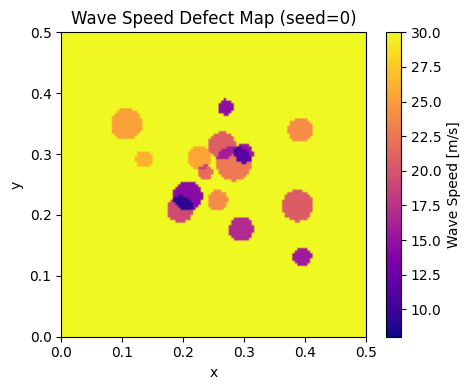

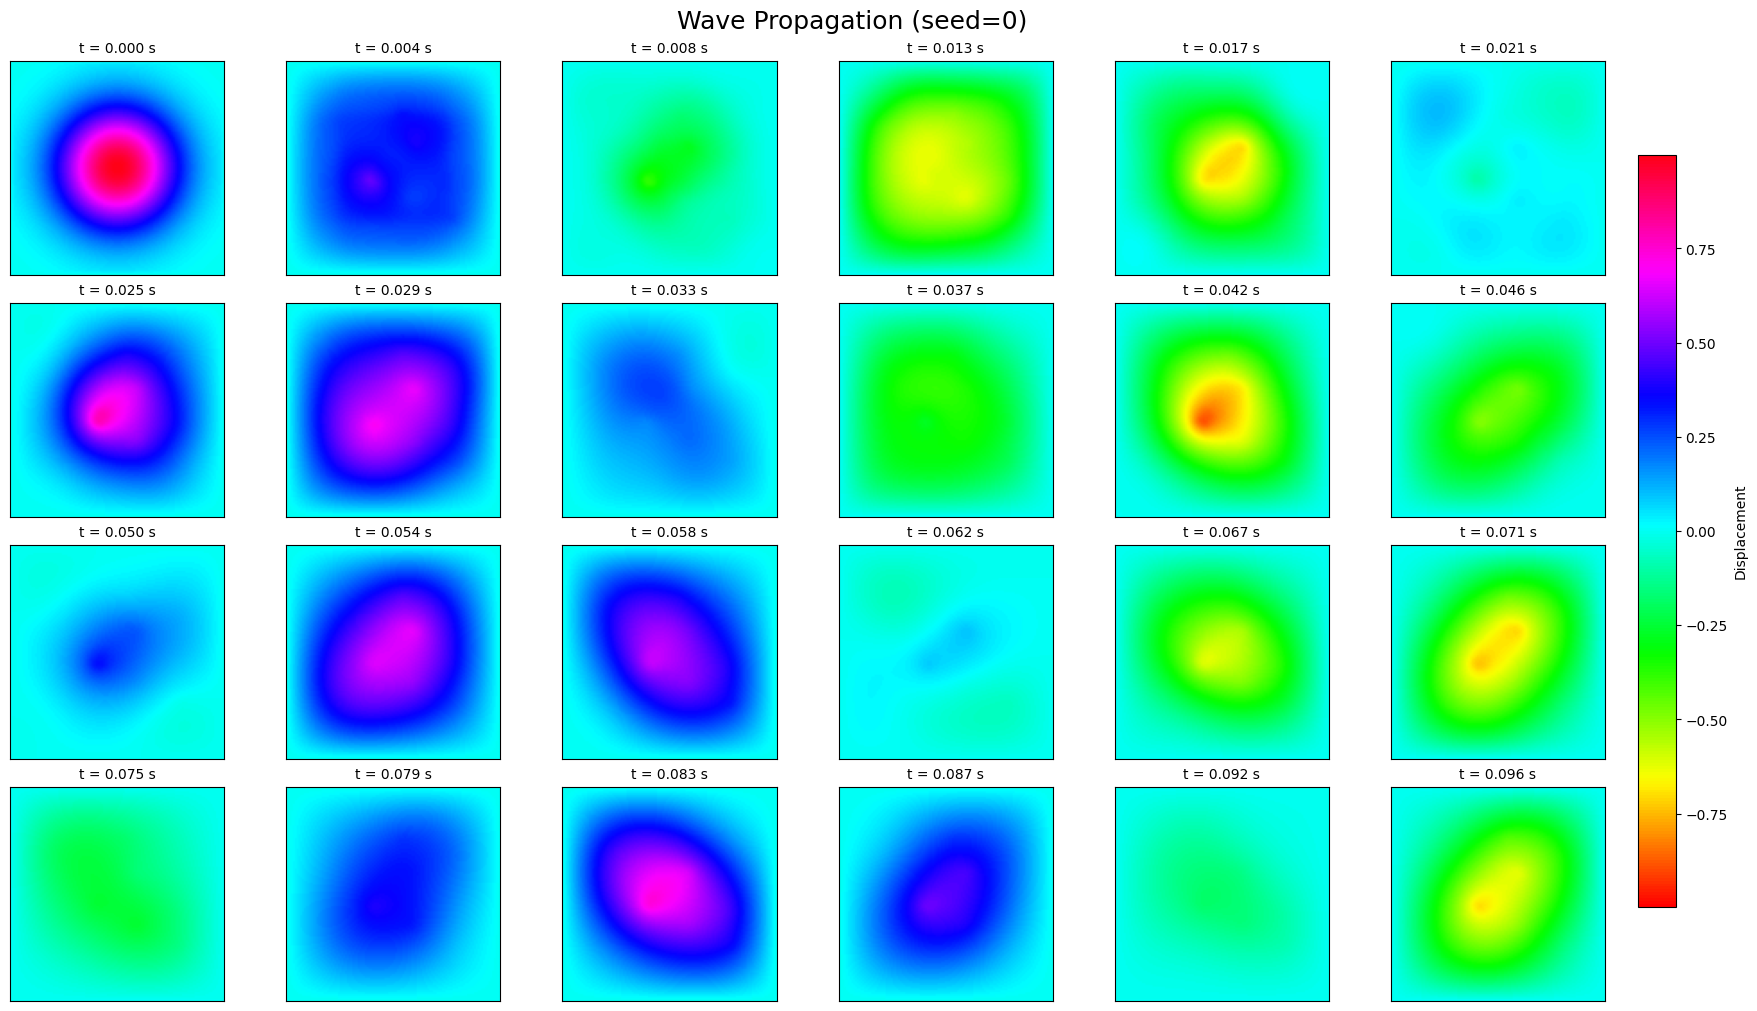

Running simulation with seed 1...


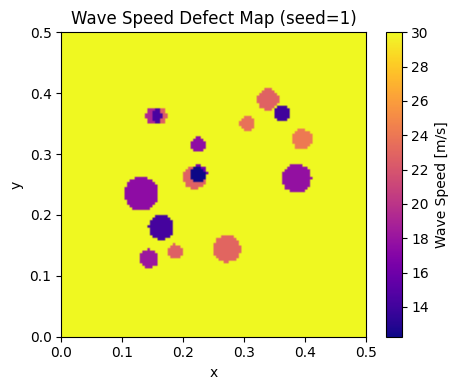

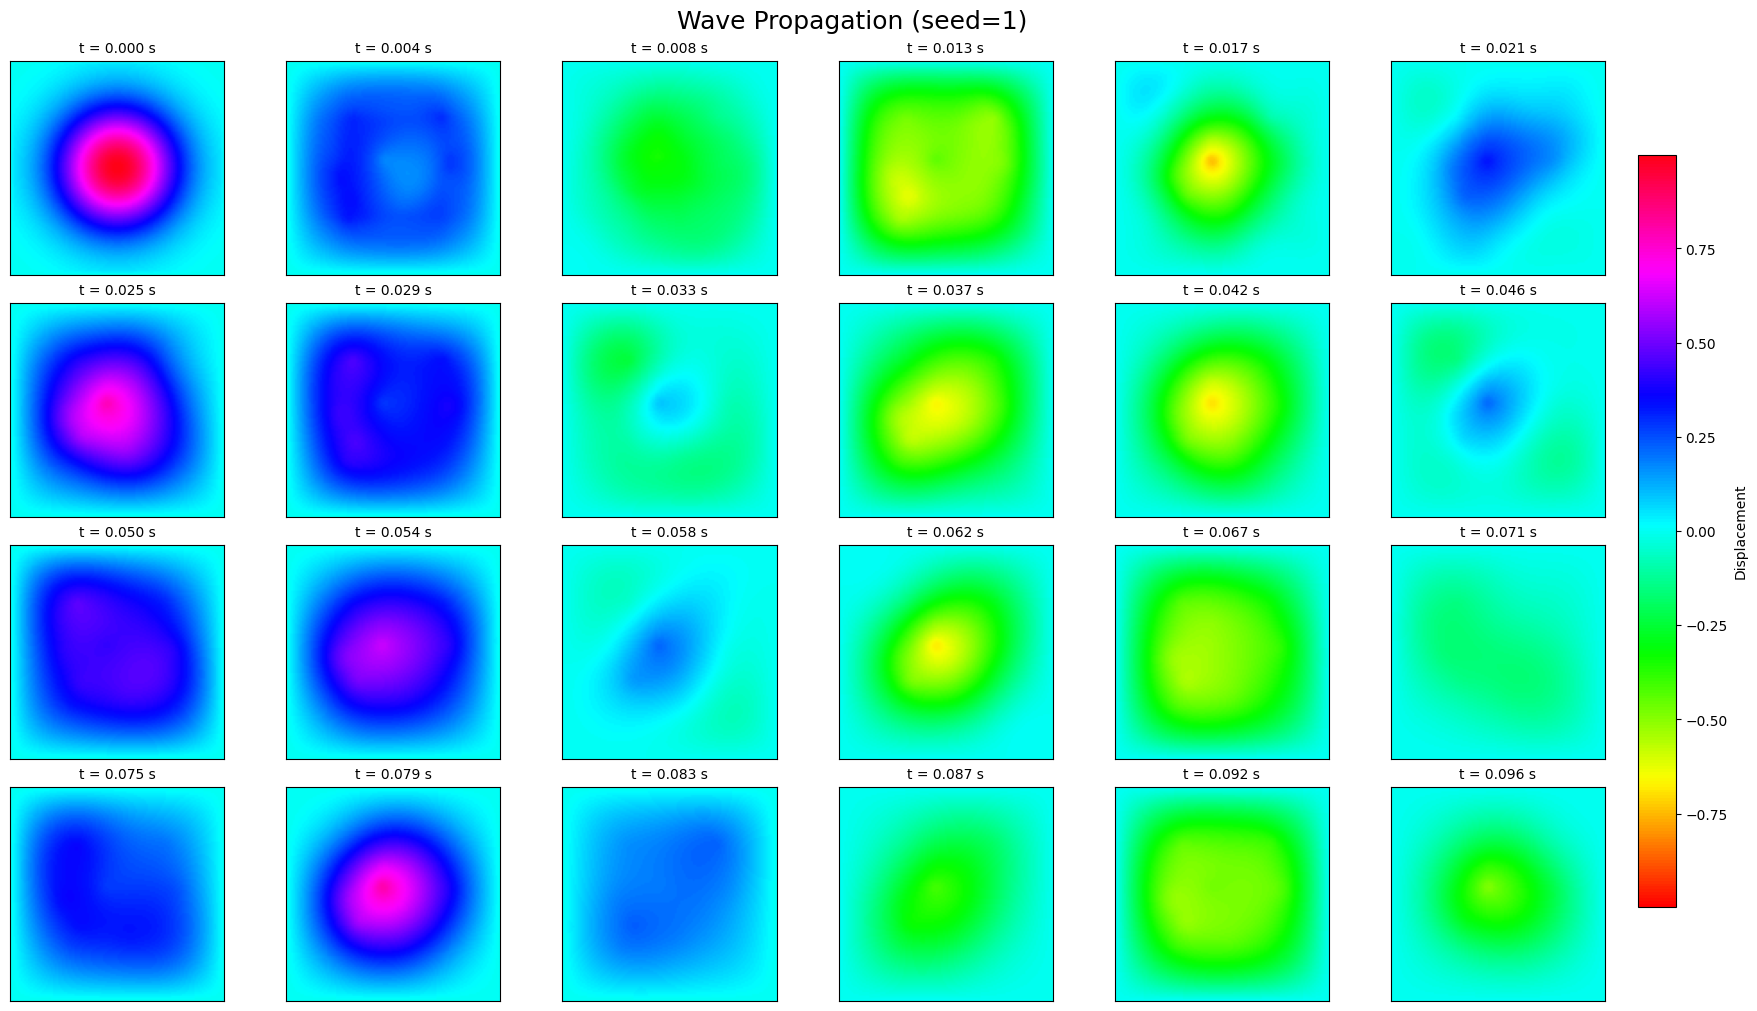

Running simulation with seed 2...


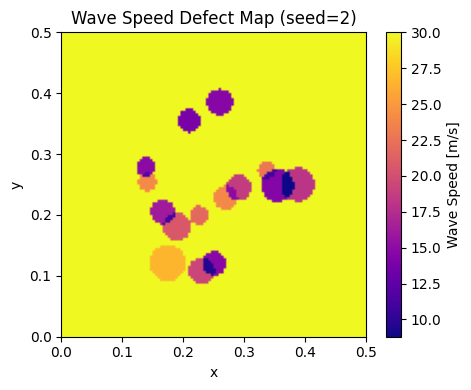

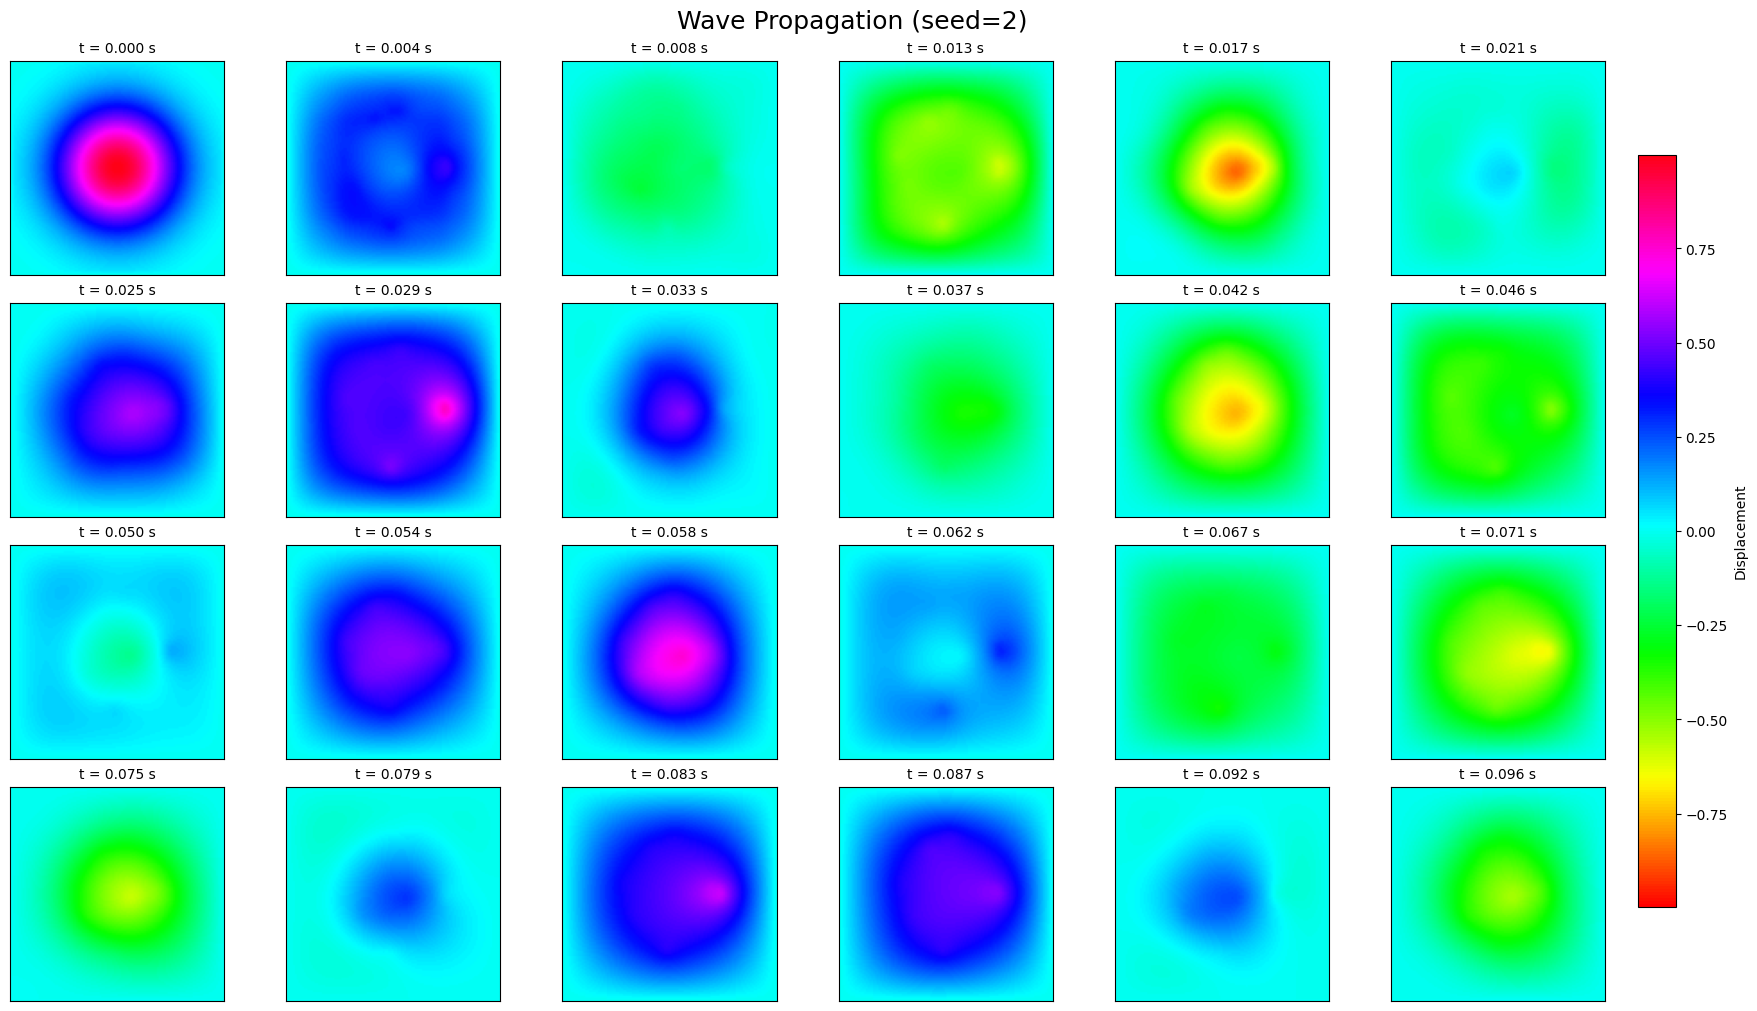

In [6]:
import numpy as np, matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, csc_matrix
from scipy.sparse.linalg import spsolve
# === Parameters ===
Lx = Ly = 0.5
c0 = 30
T = 0.1  # Total simulation time
dt = 0.0001
timesteps = int(T / dt)
def laplacian_1d(N, h):
    e = np.ones(N)
    return diags([e[:-1], -2 * e, e[:-1]], [-1, 0, 1], shape=(N, N)) / h ** 2
def laplacian_2d(Nx_int, Ny_int, dx, dy):
    Ix, Iy = identity(Nx_int), identity(Ny_int)
    Lx_1d = laplacian_1d(Nx_int, dx)
    Ly_1d = laplacian_1d(Ny_int, dy)
    return kron(Iy, Lx_1d) + kron(Ly_1d, Ix)
def make_defect_map(Nx, Ny, num_defects=15, seed=None):
    """Create a wave speed map with randomly placed circular defects."""
    if seed is not None:
        np.random.seed(seed)
    cx, cy = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny), indexing='ij')
    c_map = c0 * np.ones((Nx, Ny))
    for _ in range(num_defects):
        x0, y0 = np.random.uniform(0.1, 0.4, 2)
        r = np.random.uniform(0.012, 0.03)  # Slightly smaller defects
        strength = 1.5*np.random.uniform(0.3, 0.6)  # More pronounced (slower) defects
        mask = (cx - x0) ** 2 + (cy - y0) ** 2 <= r ** 2
        c_map[mask] *= strength
    return c_map
def run_sim(Nx, Ny, dt, timesteps, seed):
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    Nx_i, Ny_i = Nx - 2, Ny - 2
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    # Initial Conditions
    u0 = np.exp(-50 * ((X - Lx / 2) ** 2 + (Y - Ly / 2) ** 2))
    u0[[0, -1], :] = 0
    u0[:, [0, -1]] = 0
    v0 = np.zeros_like(u0)
    flatten = lambda u: u[1:-1, 1:-1].ravel()
    pad = lambda U: np.pad(U.reshape(Nx_i, Ny_i), 1)
    c_map = make_defect_map(Nx, Ny, seed=seed)
    c_inner = flatten(c_map)
    u_hist = []
    u_n, v_n = flatten(u0), flatten(v0)
    for step in range(timesteps):
        c_sq = c_inner ** 2
        L = csc_matrix(laplacian_2d(Nx_i, Ny_i, dx, dy))
        C2 = diags(c_sq)
        A = identity(Nx_i * Ny_i) - 0.5 * dt ** 2 * (C2 @ L)
        B = identity(Nx_i * Ny_i) + 0.5 * dt ** 2 * (C2 @ L)
        rhs = B @ u_n + dt * v_n
        u_np1 = spsolve(A, rhs)
        v_np1 = (u_np1 - u_n) / dt
        u_n_full = pad(u_np1)
        # Enforce Dirichlet BCs strictly each step
        u_n_full[0, :] = 0
        u_n_full[-1, :] = 0
        u_n_full[:, 0] = 0
        u_n_full[:, -1] = 0
        u_hist.append(u_n_full)
        u_n = flatten(u_n_full)
        v_n = v_np1
    return u_hist, c_map
# === Run Simulations with Different Seeds ===
Nx, Ny = 120, 120
seeds = [0, 1, 2]  # simulate 3 different defect configurations
for seed in seeds:
    print(f"Running simulation with seed {seed}...")
    u_hist, c_map = run_sim(Nx, Ny, dt, timesteps, seed=seed)
    # Plot Wave Speed Map
    plt.figure(figsize=(5, 4))
    plt.imshow(c_map.T, origin='lower', cmap='plasma', extent=[0, Lx, 0, Ly])
    plt.colorbar(label='Wave Speed [m/s]')
    plt.title(f"Wave Speed Defect Map (seed={seed})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()
    # Plot Wave Field Snapshots at 24 Equally-Spaced Times
    frame_times = np.linspace(0, T, 24, endpoint=False)
    frame_indices = (frame_times / dt).astype(int)
    all_u_vals = np.array([u_hist[idx] for idx in frame_indices])
    absmax = np.max(np.abs(all_u_vals))
    fig, axes = plt.subplots(4, 6, figsize=(18, 10), constrained_layout=True)
    for ax, idx in zip(axes.flat, frame_indices):
        im = ax.imshow(u_hist[idx].T, origin='lower', cmap='hsv', extent=[0, Lx, 0, Ly],
                       vmin=-absmax, vmax=absmax)
        ax.set_title(f"t = {idx * dt:.3f} s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label('Displacement')
    fig.suptitle(f"Wave Propagation (seed={seed})", fontsize=18)
    plt.show()